### NOTEBOOK PROJET THEORIE DE GRAPHE

Pour la partie I (representation sous forme de graphe), certaines arêtes peuvent ne pas être très visibles pour la portée 20km en raison de l'affichage par groupe. Pour une bonne visualisation dans ce cas, il faut se rendre directement à la fin du notebook et suivre les directives données en commentaires.

In [1]:
import csv
import numpy as np
import math
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def MatriceDistanceEtNoeud(ligne):
    G = nx.Graph()
    M = np.zeros((len(ligne), len(ligne)))
    for i in range(0, len(ligne)):
        G.add_node(ligne[i]['sat_id'], pos = (ligne[i]['x'], ligne[i]['y'], ligne[i]['z']))
        for j in range(0, len(ligne)):        
            if i == j:
                dist = float('inf')
            else:   
                dist = math.sqrt((float(ligne[i]['x'])/1000 - float(ligne[j]['x'])/1000)**2 + 
                                 (float(ligne[i]['y'])/1000 - float(ligne[j]['y'])/1000)**2 + 
                                 (float(ligne[i]['z'])/1000 - float(ligne[j]['z'])/1000)**2) 
            M[i, j] = dist
    return G, M



def Graph(ligne, portee):
    G, M = MatriceDistanceEtNoeud(ligne)
    #MatriceGraph = np.zeros((len(MatriceDist), len(MatriceDist)))
    
    for i in range(0, len(M)):
        for j in range(0, len(M)):
            if M[i, j] <= portee:
                G.add_edge(ligne[i]['sat_id'], ligne[j]['sat_id'])
    return G


def GraphWeight60k(ligne):
    G, M = MatriceDistanceEtNoeud(ligne)
    #MatriceGraph = np.zeros((len(MatriceDist), len(MatriceDist)))
    for i in range(0, len(M)):
        for j in range(0, len(M)): 
            if M[i, j] <= 60:
                G.add_edge(ligne[i]['sat_id'], ligne[int(j)]['sat_id'], weight = M[i, j]**2) 
    return G
   

In [2]:
#Permet d'obtenir toutes les caracteristiques et les afficher
def analyze_graph_characteristics(path, portee, title):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection  = '3d')
    
    fichier = open(path, 'r')
    contenu = csv.DictReader(fichier) 
    ligne = list(contenu)
    G = Graph(ligne, portee)
    fichier.close()
    
    Lx = np.zeros(len(ligne))
    Ly = np.zeros(len(ligne))
    Lz = np.zeros(len(ligne))
    
    #Crée des listes contenant les valeurs xi, yi et zi
    for i in range(0, len(ligne)):
        Lx[i] = float(ligne[i]['x'])/1000
        Ly[i] = float(ligne[i]['y'])/1000
        Lz[i] = float(ligne[i]['z'])/1000
    
    ax.scatter(Lx, Ly, Lz, c = 'blue', s = 50)
    
    # Pour chaque arête, tracer la ligne entre les satellites connectés
    for edge in G.edges():
        # Récupérer les coordonnées des deux satellites
        x1, y1, z1 = float(ligne[int(edge[0])]['x'])/1000, float(ligne[int(edge[0])]['y'])/1000, float(ligne[int(edge[0])]['z'])/1000
        x2, y2, z2 = float(ligne[int(edge[1])]['x'])/1000, float(ligne[int(edge[1])]['y'])/1000, float(ligne[int(edge[1])]['z'])/1000
        
        # Tracer la ligne entre les deux satellites
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'gray', alpha=0.5)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
    # Analyse du graphe
    degree = [d[1] for d in G.degree]
    degree_moyen = sum(degree)/G.number_of_nodes()
    
    # Distribution des degrés de clustering
    cluster_distrib = nx.clustering(G)
    
    # Longueur des plus courts chemin
    shortest_path_length = dict(nx.shortest_path_length(G))
    df = pd.DataFrame(shortest_path_length).fillna("∞") # Pour afficher les plus courts chemins dans une matrice    
    
    # Récupère les distances des plus courts chemins en évitant de récupérer les doublons
    # Par exemple on récupère le plus court chemins entre 1 et 15 mais on ne récupère pas celui entre 15 et 1
    # qui est le même.
    dist = []
 
    for i in range(0, len(shortest_path_length)):
        key = shortest_path_length[str(i)].keys()
        for j in key:
            if int(j) > i:
                dist.append(shortest_path_length[str(i)][str(j)])   
    
    dist2=dict(nx.all_pairs_all_shortest_paths(G))
    # Initialisation du compteur
    total_shortest_paths = 0

    # Parcourir toutes les paires de nœuds pour compter les chemins
    for source, target_paths in dist2.items():
        for target, paths in target_paths.items():
            total_shortest_paths += len(paths)

    total_shortest_paths-=G.number_of_nodes()
    total_shortest_paths/=2
    total_shortest_paths=int(total_shortest_paths)

    
    
    print("-----------------------------------------Information sur le graphe-----------------------------------------")
    print("Nombre de noeud: " + str(G.number_of_nodes()))
    print("Nombre d'arêtes: " + str(G.number_of_edges()))
    print("Degrée moyen du graph: " + str(degree_moyen))
    print("Coefficient de clustering moyen: " + str(nx.average_clustering(G)))
    # Très long à calculer pour une portée de 60km
    #print("Nombre de cliques: " + str(len(list(nx.enumerate_all_cliques(G))))) 
    print("Nombre de composantes connexes: " + str(nx.number_connected_components(G)))
    print("Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: " + str(len((dist))))
    print(f"Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: {total_shortest_paths}")
    print("\nMatrice des longueurs des chemins les plus courts:\n ")
    print(df)
    print("----------------------------------------------------------------------------------------------------------")
 
    return G, degree, cluster_distrib, dist

#afficher les histogrammes presentant les distributions et les caracteristiques
def plot_graph_histograms(G, degree, cluster_distrib, dist):
    
   # Histogramme des degrés
    plt.figure()
    max_degree = max(degree)
    bins = range(max_degree + 2)  # +2 pour inclure la dernière valeur
    plt.hist(degree, bins=bins, color='yellow', edgecolor='red', align='left')
    #Calcul d'un espacement adaptatif pour les étiquettes
    if max_degree > 20:
        # Si beaucoup de valeurs, on affiche un nombre réduit d'étiquettes
        step = max(1, max_degree // 10)  # Divise l'axe en ~10 étiquettes
        xticks = range(0, max_degree + 1, step)
    else:
        # Si peu de valeurs, on peut toutes les afficher, Valeurs entières uniquement
        xticks = range(0, max_degree + 1)
    plt.xticks(xticks, rotation=45 if max_degree > 20 else 0)  # Rotation si beaucoup de valeurs
    # Ajout d'une grille verticale pour faciliter la lecture
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlabel('Degré')
    plt.ylabel('Nombre de sommets')
    plt.title('Distribution du degré des sommets')
    # Ajuste automatiquement les marges pour éviter que les étiquettes soient coupées
    plt.tight_layout()
    plt.show()

    # Histogramme des degrès de clusterings
    plt.figure()
    # Extraire les valeurs du degré de clustering
    cluster_values = [cluster_distrib[str(i)] for i in range(1, len(cluster_distrib))]
    # Définir les bornes des intervalles (bins) tous les 0.05
    bins = np.arange(0.0, 1.05, 0.05)
    # Créer l'histogramme
    plt.hist(cluster_values, bins=bins, color='yellow', edgecolor='red', align='mid')
    # Ajuster les ticks des abscisses pour mieux afficher les valeurs
    plt.xticks(bins, rotation=45)
    plt.xlabel('Degré de clustering (par tranches de 0.05)')
    plt.ylabel('Nombre de sommets')
    plt.title('Distribution du degré de clustering')
    plt.show()

    # Histogramme des cliques
    # Peut être très long pour une portee de 60km
    #plt.figure()
    #clique_sizes = [len(clique) for clique in list(nx.enumerate_all_cliques(G))[1:]]
    #max_clique_size = max(clique_sizes)
    #bins = range(max_clique_size + 2)  # +2 pour inclure la dernière valeur
    #plt.hist(clique_sizes, bins=bins, color='yellow', edgecolor='red', align='left')
    #plt.xticks(range(0, max_clique_size + 1))
    #plt.xlabel('Nombre de sommets')
    #plt.ylabel('Nombre de cliques')
    #plt.title('Distribution du nombre de sommets par clique')
    #plt.show()
    
    # Histogramme des composantes connexes
    plt.figure()
    component_sizes = [len(comp) for comp in nx.connected_components(G)]
    max_component_size = max(component_sizes)
    bins = range(max_component_size + 2)
    plt.hist(component_sizes, bins=bins, color='yellow', edgecolor='red', align='left')

    # Calcul d'un espacement adaptatif pour les étiquettes
    if max_component_size > 20:
        # Si beaucoup de valeurs, on affiche un nombre réduit d'étiquettes
        step = max(1, max_component_size // 10)  # Divise l'axe en ~10 étiquettes
        xticks = range(0, max_component_size + 1, step)
    else:
        # Si peu de valeurs, on peut toutes les afficher
        xticks = range(0, max_component_size + 1)

    plt.xticks(xticks, rotation=45 if max_component_size > 60 else 0)  # Rotation si beaucoup de valeurs
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Ajout d'une grille pour faciliter la lecture
    plt.xlabel('Nombre de sommets')
    plt.ylabel('Composantes connexes')
    plt.title('Distribution du nombre de sommets par composantes connexes')
    plt.tight_layout()  # Ajuste automatiquement les marges
    plt.show()

    # Histogramme des plus courts chemins
    plt.figure()
    max_path_length = max(dist)
    bins = range(max_path_length + 2)
    plt.hist(dist, bins=bins, color='yellow', edgecolor='red', align='left')
    plt.xticks(range(0, max_path_length + 1))
    plt.xlabel('Longueur des plus courts chemins')
    plt.ylabel('Nombre de plus courts chemins')
    plt.title('Distribution de la longueur des plus courts chemins')
    plt.show()

def plot_satellite(path, portee, title,affiche):
    G, degree, cluster_distrib, dist = analyze_graph_characteristics(path, portee, title)
    if affiche :
        plot_graph_histograms(G, degree, cluster_distrib, dist)
    
#POUR TOUT AFFICHER     
def analyze_all(affiche):
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    for i in range(0, len(tabs)):
        path = tabs[i]
        title = titles[i]
        for portee in portees:
            plot_satellite(path, portee, title + " avec portee = " + str(portee),affiche)
            print("\n\n")

In [3]:
#ADAPTATION POUR LA PARTIE 3 : GRAHE PONDERE

def analyze_graph_characteristics_exercice3(path, title):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection  = '3d')
    
    fichier = open(path, 'r')
    contenu = csv.DictReader(fichier) 
    ligne = list(contenu)
    fichier.close()
    
    # Crée le nouveau graphe en rajoutant le poid (distance²) pour chaque arêtes
    GW60 = GraphWeight60k(ligne)
    
    Lx = np.zeros(len(ligne))
    Ly = np.zeros(len(ligne))
    Lz = np.zeros(len(ligne))
    
    #Crée des listes contenant les valeurs xi, yi et zi
    for i in range(0, len(ligne)):
        Lx[i] = float(ligne[i]['x'])/1000
        Ly[i] = float(ligne[i]['y'])/1000
        Lz[i] = float(ligne[i]['z'])/1000
    
    ax.scatter(Lx, Ly, Lz, c = 'blue', s = 50)
    
    # Pour chaque arête, tracer la ligne entre les satellites connectés
    for edge in GW60.edges():
        # Récupérer les coordonnées des deux satellites
        x1, y1, z1 = float(ligne[int(edge[0])]['x'])/1000, float(ligne[int(edge[0])]['y'])/1000, float(ligne[int(edge[0])]['z'])/1000
        x2, y2, z2 = float(ligne[int(edge[1])]['x'])/1000, float(ligne[int(edge[1])]['y'])/1000, float(ligne[int(edge[1])]['z'])/1000
        
        # Tracer la ligne entre les deux satellites
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'gray', alpha=0.5)
        
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()
    
    # Analyse du graphe
    degree = [d[1] for d in GW60.degree]
    degree_moyen = sum(degree)/GW60.number_of_nodes()
    
    # Distribution des degrés de clustering
    cluster_distrib = nx.clustering(GW60)
    
    # Longueur des plus courts chemin     
    shortest_path_lengthW60 = dict(nx.all_pairs_dijkstra_path_length(GW60, weight='weight'))
    df = pd.DataFrame(shortest_path_lengthW60).fillna("∞")
    df = df.sort_index()
    
    # Récupère les distances des plus courts chemins en évitant de récupérer les doublons
    # Par exemple on récupère le plus court chemins entre 1 et 15 mais on ne récupère pas celui entre 15 et 1
    # qui est le même.
    dist = []
 
    for i in range(0, len(shortest_path_lengthW60)):
        key = shortest_path_lengthW60[str(i)].keys()
        for j in key:
            if int(j) > i:
                dist.append(shortest_path_lengthW60[str(i)][str(j)])   
    
    
    dist2=dict(nx.all_pairs_all_shortest_paths(GW60, weight="weight"))
    # Initialisation du compteur
    total_shortest_paths = 0
    # Parcourir toutes les paires de nœuds pour compter les chemins
    for source, target_paths in dist2.items():
        for target, paths in target_paths.items():
            total_shortest_paths += len(paths)

    total_shortest_paths-=GW60.number_of_nodes()
    total_shortest_paths/=2
    total_shortest_paths=int(total_shortest_paths)

    
    
    print("-----------------------------------------Information sur le graphe-----------------------------------------")
    print("Nombre de noeud: " + str(GW60.number_of_nodes()))
    print("Nombre d'arêtes: " + str(GW60.number_of_edges()))
    print("Degrée moyen du graph: " + str(degree_moyen))
    print("Coefficient de clustering moyen: " + str(nx.average_clustering(GW60)))
    #print("Nombre de cliques: " + str(len(list(nx.enumerate_all_cliques(GW60)))))
    print("Nombre de composantes connexes: " + str(nx.number_connected_components(GW60)))
    print("Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: " + str(len((dist))))
    print(f"Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: {total_shortest_paths}")
    print("\nMatrice des longueurs des chemins les plus courts:\n ")
    print(df)
    print("----------------------------------------------------------------------------------------------------------")

    return GW60, degree, cluster_distrib, dist

def plot_graph_histograms_exercice3(GW60, degree, cluster_distrib, dist):

   # Histogramme des degrés
    plt.figure()
    max_degree = max(degree)
    bins = range(max_degree + 2)  # +2 pour inclure la dernière valeur
    plt.hist(degree, bins=bins, color='yellow', edgecolor='red', align='left')
    #Calcul d'un espacement adaptatif pour les étiquettes
    if max_degree > 20:
        # Si beaucoup de valeurs, on affiche un nombre réduit d'étiquettes
        step = max(1, max_degree // 10)  # Divise l'axe en ~10 étiquettes
        xticks = range(0, max_degree + 1, step)
    else:
        # Si peu de valeurs, on peut toutes les afficher, Valeurs entières uniquement
        xticks = range(0, max_degree + 1)
    plt.xticks(xticks, rotation=45 if max_degree > 20 else 0)  # Rotation si beaucoup de valeurs
    # Ajout d'une grille verticale pour faciliter la lecture
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlabel('Degré')
    plt.ylabel('Nombre de sommets')
    plt.title('Distribution du degré des sommets')
    # Ajuste automatiquement les marges pour éviter que les étiquettes soient coupées
    plt.tight_layout()
    plt.show()
    
    # Histogramme des degrès de clusterings
    plt.figure()
    # Extraire les valeurs du degré de clustering
    cluster_values = [cluster_distrib[str(i)] for i in range(1, len(cluster_distrib))]
    # Définir les bornes des intervalles (bins) tous les 0.05
    bins = np.arange(0.0, 1.05, 0.05)
    # Créer l'histogramme
    plt.hist(cluster_values, bins=bins, color='yellow', edgecolor='red', align='mid')
    # Ajuster les ticks des abscisses pour mieux afficher les valeurs
    plt.xticks(bins, rotation=45)
    plt.xlabel('Degré de clustering (par tranches de 0.05)')
    plt.ylabel('Nombre de sommets')
    plt.title('Distribution du degré de clustering')
    plt.show()
    

    # Histogramme des composantes connexes
    plt.figure()
    component_sizes = [len(comp) for comp in nx.connected_components(GW60)]
    max_component_size = max(component_sizes)
    bins = range(max_component_size + 2)
    plt.hist(component_sizes, bins=bins, color='yellow', edgecolor='red', align='left')

    # Calcul d'un espacement adaptatif pour les étiquettes
    if max_component_size > 20:
        # Si beaucoup de valeurs, on affiche un nombre réduit d'étiquettes
        step = max(1, max_component_size // 10)  # Divise l'axe en ~10 étiquettes
        xticks = range(0, max_component_size + 1, step)
    else:
        # Si peu de valeurs, on peut toutes les afficher
        xticks = range(0, max_component_size + 1)

    plt.xticks(xticks, rotation=45 if max_component_size > 60 else 0)  # Rotation si beaucoup de valeurs
    plt.grid(axis='x', linestyle='--', alpha=0.7)  # Ajout d'une grille pour faciliter la lecture
    plt.xlabel('Nombre de sommets')
    plt.ylabel('Composantes connexes')
    plt.title('Distribution du nombre de sommets par composantes connexes')
    plt.tight_layout()  # Ajuste automatiquement les marges
    plt.show()

    # Histogramme des plus courts chemins
    plt.figure()
    # Définir les bornes des intervalles (bins) tous les 500
    max_path_length = max(dist)
    bins = min(20, max_path_length)  # Limite le nombre de barres à 20 maximum pour la lisibilité
    plt.hist(dist, bins=bins, color='yellow', edgecolor='red', align='left')
    # Ajuster les ticks des abscisses pour mieux afficher les valeurs
    plt.xticks(range(0, int(max_path_length) + 1, max(1, int(max_path_length) // 10)), rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.xlabel('Longueur des plus courts chemins')
    plt.ylabel('Nombre de plus courts chemins')
    plt.title('Distribution de la longueur des plus courts chemins')
    plt.show()
    
def plot_satellite_exercice3(path, title,affiche):
    GW60, degree, cluster_distrib, dist = analyze_graph_characteristics_exercice3(path, title)
    if affiche :
        plot_graph_histograms_exercice3(GW60, degree, cluster_distrib, dist)
    
def analyze_all_exercice3(affiche=False):
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    for i in range(0, len(tabs)):
        path = tabs[i]
        title = titles[i]
        plot_satellite_exercice3(path, title + " avec portee = " + str(portees[0]),affiche)
        print("\n\n")

### PARTIE I -VISUALISATION DE LA MODELISATION SOUS FORME DE GRAPHE DE L'ESSAIM 

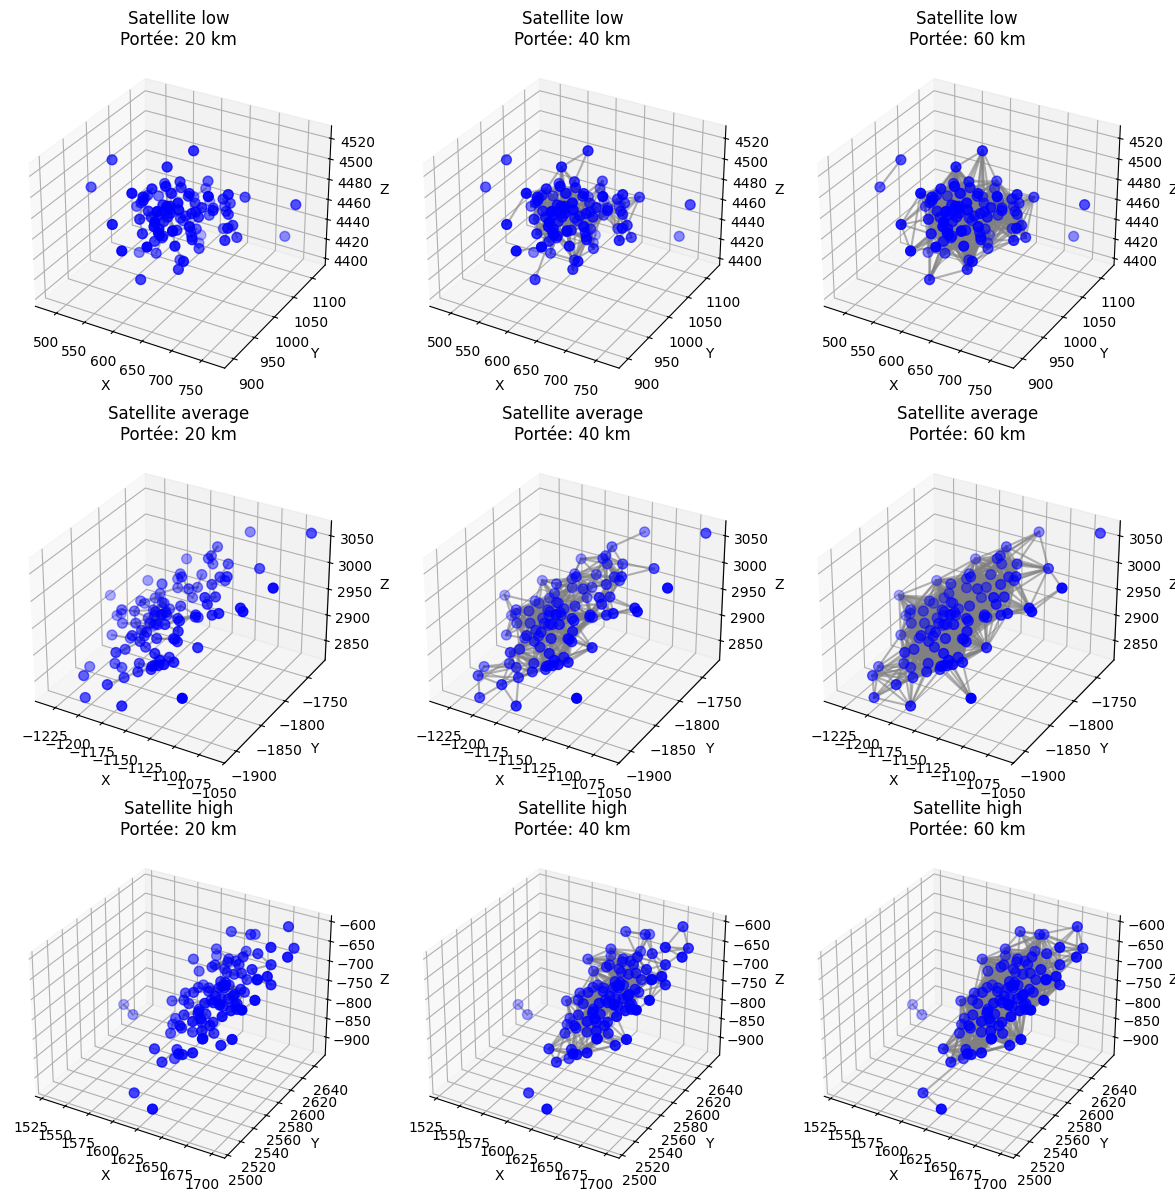

In [4]:
#AFFICHAGE DE TOUS LES GRAPHES

def all_Graph(): 
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']

    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12), subplot_kw={'projection': '3d'})

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            fichier = open(path, 'r')
            contenu = csv.DictReader(fichier) 
            ligne = list(contenu)
            G = Graph(ligne, portee)
            fichier.close()

            Lx = np.zeros(len(ligne))
            Ly = np.zeros(len(ligne))
            Lz = np.zeros(len(ligne))

            # Remplissage des listes de coordonnées
            for k in range(len(ligne)):
                Lx[k] = float(ligne[k]['x']) / 1000
                Ly[k] = float(ligne[k]['y']) / 1000
                Lz[k] = float(ligne[k]['z']) / 1000

            ax.scatter(Lx, Ly, Lz, c='blue', s=50)
            
            # Ajouter les numéros des sommets
            #for k in range(len(ligne)):
                #ax.text(Lx[k], Ly[k], Lz[k], str(k), color='red')

            # Tracer les arêtes du graphe
            for edge in G.edges():
                x1, y1, z1 = float(ligne[int(edge[0])]['x'])/1000, float(ligne[int(edge[0])]['y'])/1000, float(ligne[int(edge[0])]['z'])/1000
                x2, y2, z2 = float(ligne[int(edge[1])]['x'])/1000, float(ligne[int(edge[1])]['y'])/1000, float(ligne[int(edge[1])]['z'])/1000

                ax.plot([x1, x2], [y1, y2], [z1, z2], 'gray', alpha=0.6)

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f"{title}\nPortée: {portee} km")

    plt.tight_layout()
    plt.show()

all_Graph()

### PARTIE II 

#### DISTRIBUTION DE DEGRE

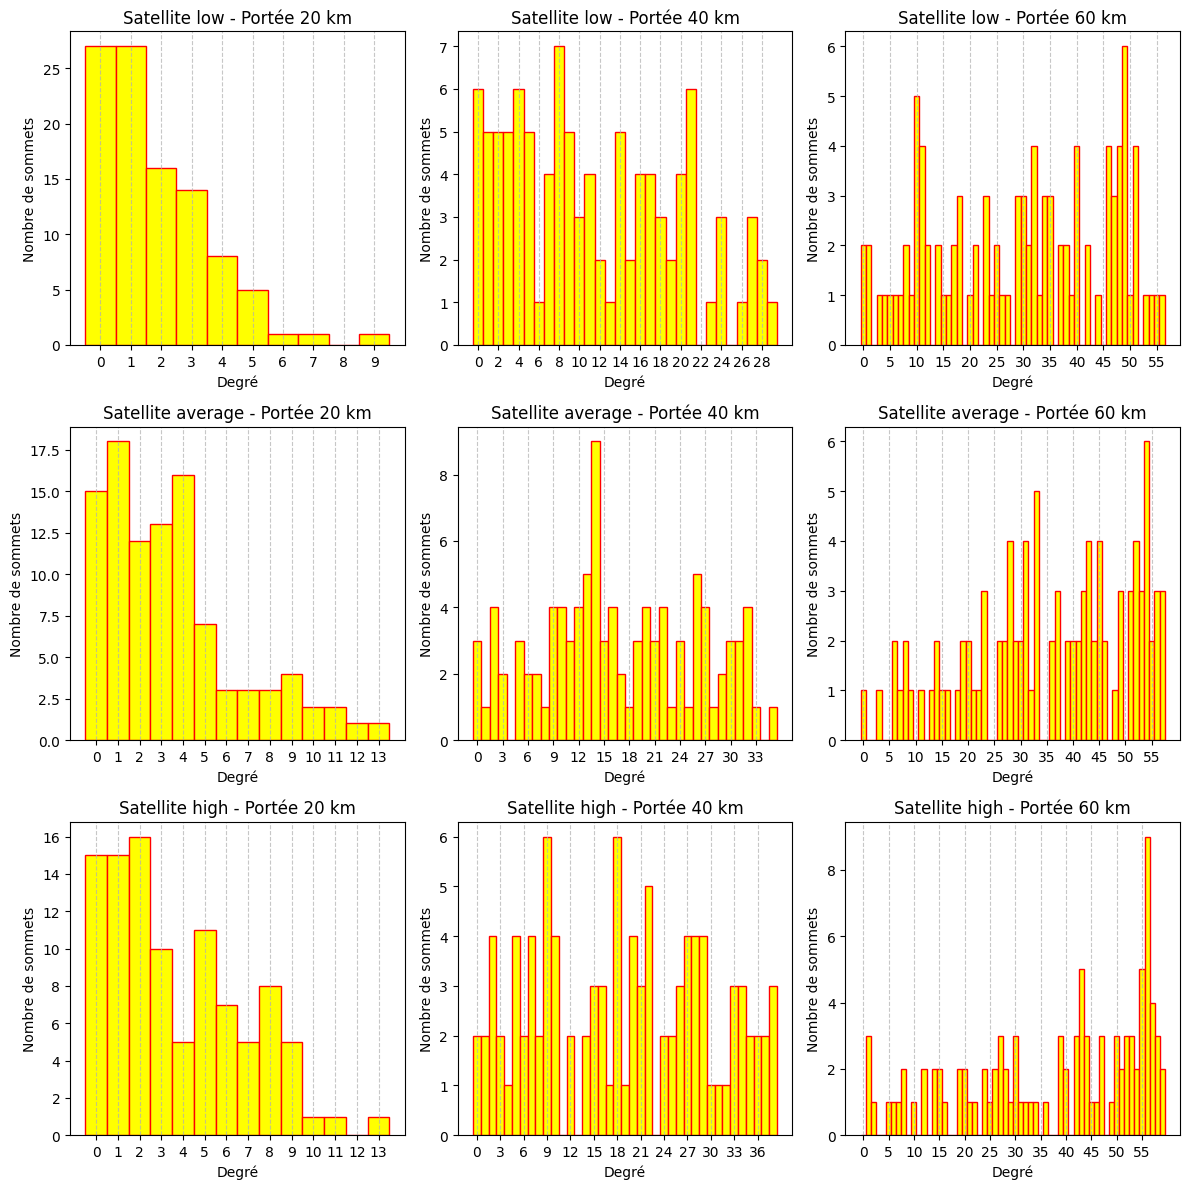

In [5]:
#AFFICHAGE DE LA DISTRIBUTION DE DEGRE 
def all_degree_density():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            with open(path, 'r') as fichier:
                contenu = csv.DictReader(fichier)
                ligne = list(contenu)

            G = Graph(ligne, portee)

            # Récupérer les degrés des sommets
            degree_values = [deg for _, deg in G.degree()]
            
            if degree_values:
                max_degree = max(degree_values)
            else:
                max_degree = 0  # Si le graphe est vide

            bins = range(max_degree + 2)  # +2 pour inclure la dernière valeur

            # Tracer l'histogramme des degrés
            ax.hist(degree_values, bins=bins, color='yellow', edgecolor='red', align='left')

            # Calcul d'un espacement adaptatif pour les étiquettes
            if max_degree > 20:
                step = max(1, max_degree // 10)
                xticks = range(0, max_degree + 1, step)
            else:
                xticks = range(0, max_degree + 1)

            ax.set_xticks(xticks)
            ax.set_xlabel('Degré')
            ax.set_ylabel('Nombre de sommets')
            ax.set_title(f'{title} - Portée {portee} km')

            ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

all_degree_density()
    

#### DISTRIBUTION DE DEGRE DE CLUSTERING

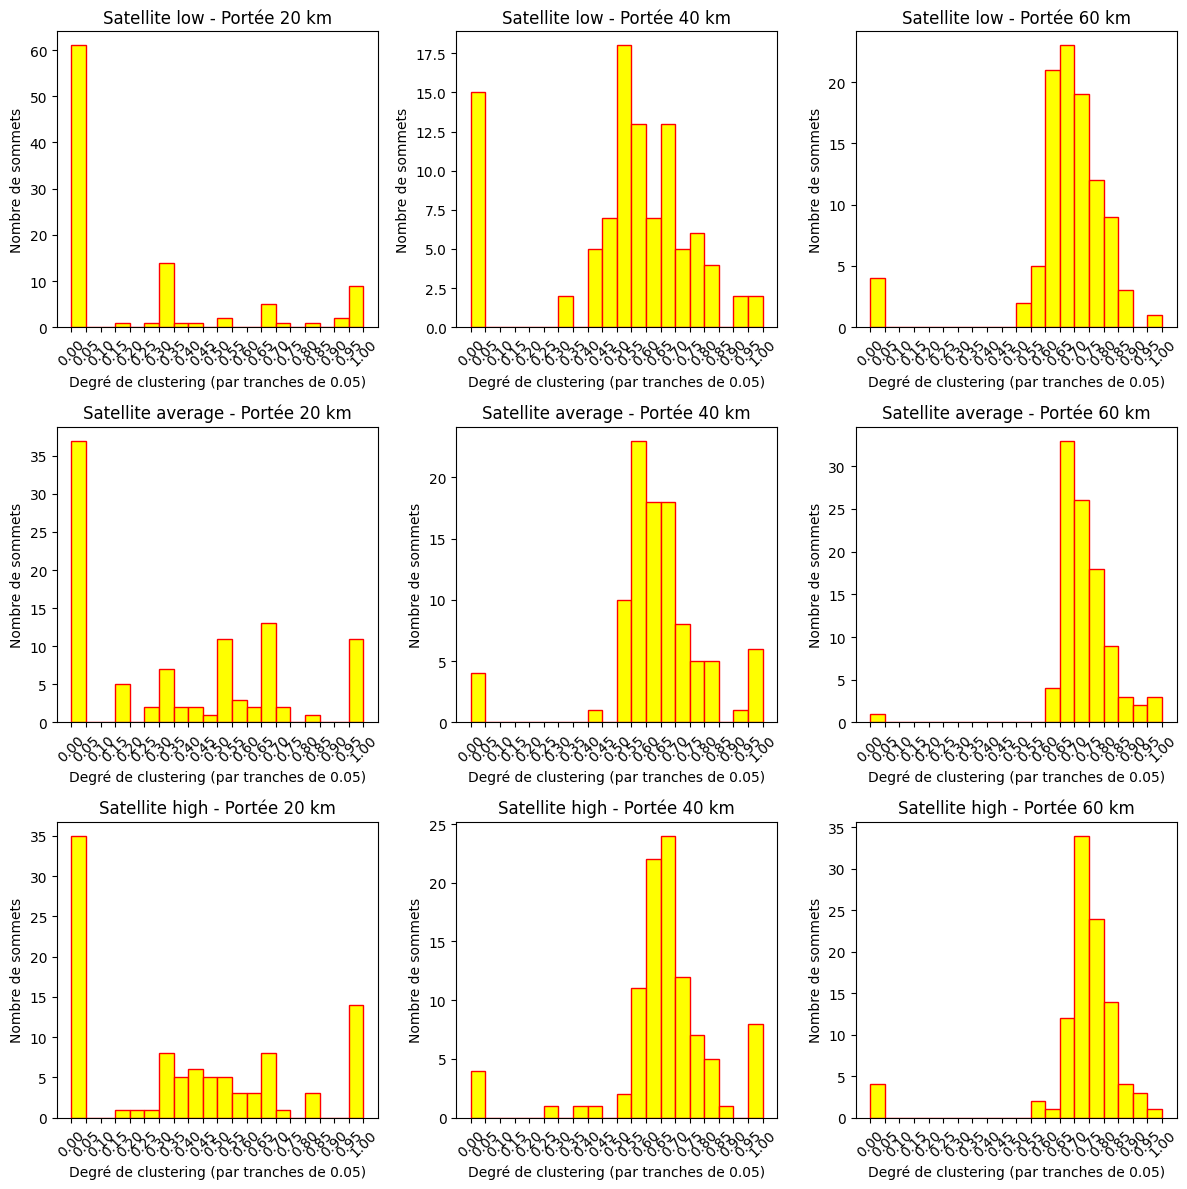

In [6]:
#AFFICHAGE DE LA DISTRIBUTION DE CLUSTERING
def all_clustering_density():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            with open(path, 'r') as fichier:
                contenu = csv.DictReader(fichier)
                ligne = list(contenu)

            G = Graph(ligne, portee)
            cluster_distrib = nx.clustering(G)
            
            # Extraire les valeurs du degré de clustering
            cluster_values = [cluster_distrib[str(i)] for i in range(1, len(cluster_distrib))]
            
            # Définir les bornes des intervalles (bins) tous les 0.05
            bins = np.arange(0.0, 1.05, 0.05)
            
            # Créer l'histogramme
            ax.hist(cluster_values, bins=bins, color='yellow', edgecolor='red', align='mid')
            
            # Ajuster les ticks des abscisses pour mieux afficher les valeurs
            ax.set_xticks(bins)
            plt.setp(ax.get_xticklabels(), rotation=45)
            
            ax.set_xlabel('Degré de clustering (par tranches de 0.05)')
            ax.set_ylabel('Nombre de sommets')
            ax.set_title(f'{title} - Portée {portee} km')
            
    plt.tight_layout()
    plt.show()

all_clustering_density()
    

#### DISTRIBUTION DE CLIQUES (NOMBRE DE CLIQUE PAR ORDRE(NOMBRE DE SOMMETS))

Pour une portée de 60 km ,le graphe généré est plus dense. Et par conséquent, un nombre exponentiellement plus grand de cliques, ce qui entraîne un temps de calcul  trop long. Raison pour laquelle,nous avons retiré la valeur 60 km dans le tableau portees . Pour tenter d'obtenir le resultat pour les cliques de 60 km, ajouter la valeur 60 dans le tableau.


Nombre de cliques du Satellite low avec une portée de 20 km = 239
Nombre de cliques du Satellite low avec une portée de 40 km = 22854
Nombre de cliques du Satellite average avec une portée de 20 km = 634
Nombre de cliques du Satellite average avec une portée de 40 km = 252390
Nombre de cliques du Satellite high avec une portée de 20 km = 519
Nombre de cliques du Satellite high avec une portée de 40 km = 3175925


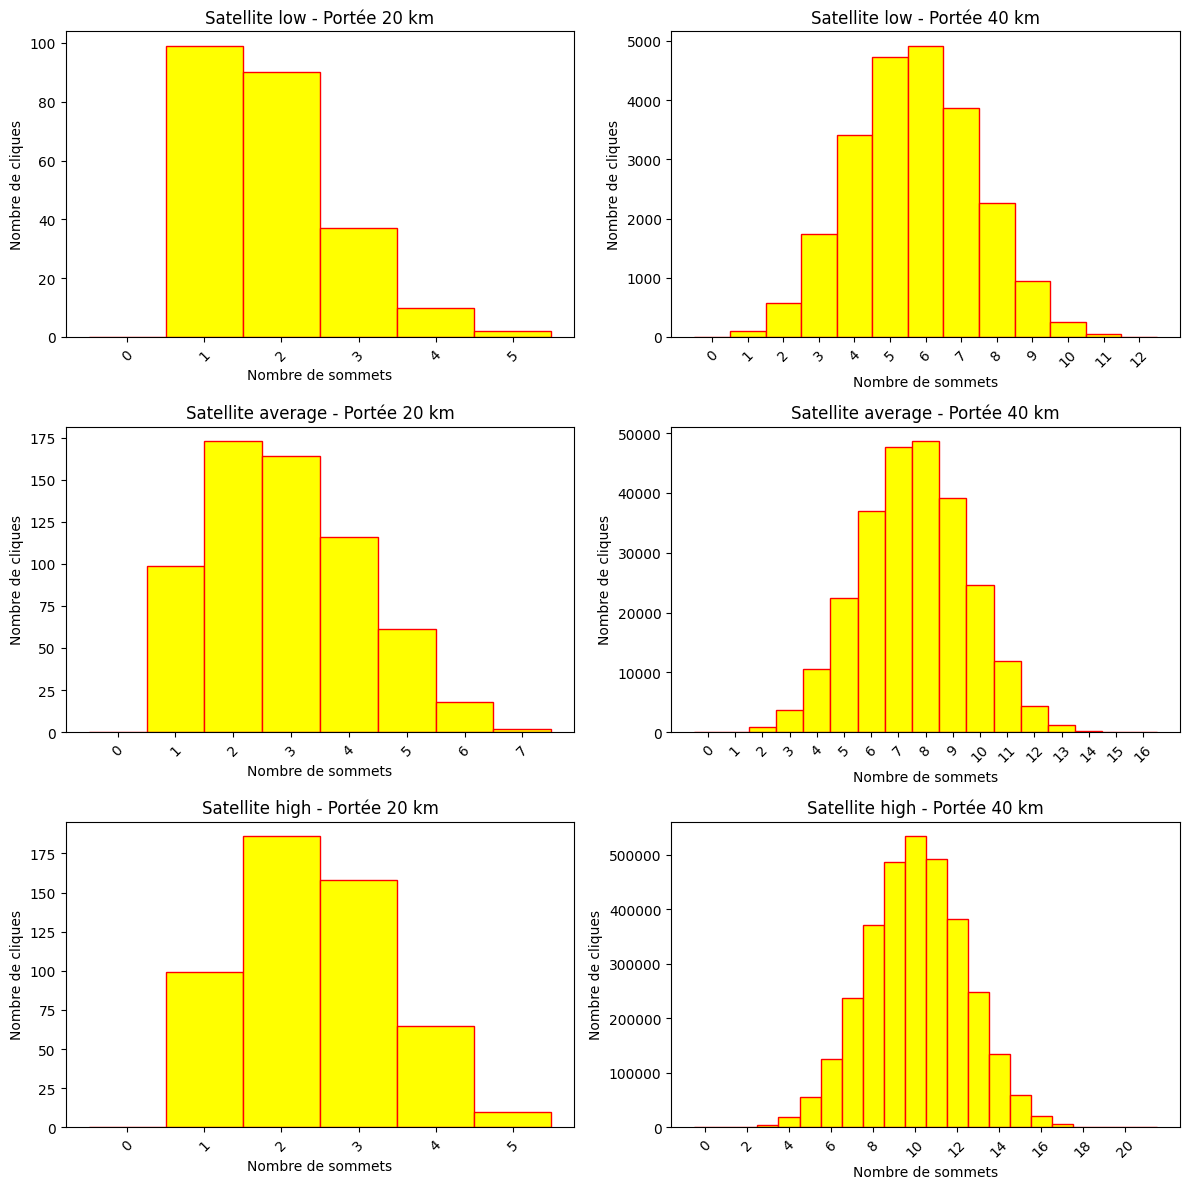

In [7]:
def all_clique_density():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40] #ajouter 60 dans ce tableau, peut être très long
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            with open(path, 'r') as fichier:
                contenu = csv.DictReader(fichier)
                ligne = list(contenu)

            G = Graph(ligne, portee)

            # Histogramme des cliques
            # Peut être très long pour une portee de 60km
            liste_clique=list(nx.enumerate_all_cliques(G))
            clique_sizes = [len(clique) for clique in (liste_clique)[1:]]
            print("Nombre de cliques du "+ title +" avec une portée de "+str(portee) + " km = " +str(len((liste_clique))))
            
            max_clique_size = max(clique_sizes)
            
            if max_clique_size > 20:
                step = max(1, max_clique_size // 10)
                xticks = range(0, max_clique_size + 1, step)
            else:
                xticks = range(0, max_clique_size + 1)
                
            bins = range(max_clique_size + 2)  # +2 pour inclure la dernière valeur
            
            ax.hist(clique_sizes, bins=bins, color='yellow', edgecolor='red', align='left')
            ax.set_xticks(xticks)
            plt.setp(ax.get_xticklabels(), rotation=45) # Rotation si beaucoup de valeurs
            ax.set_xlabel('Nombre de sommets')
            ax.set_ylabel('Nombre de cliques')
            ax.set_title(f'{title} - Portée {portee} km')

    plt.tight_layout()
    plt.show()

all_clique_density()

#### DISTRIBUTION DE COMPOSANTE CONNEXE ( NOMBRE DE COMPOSANTE CONNEXE PAR NOMBRE DE SOMMETS)

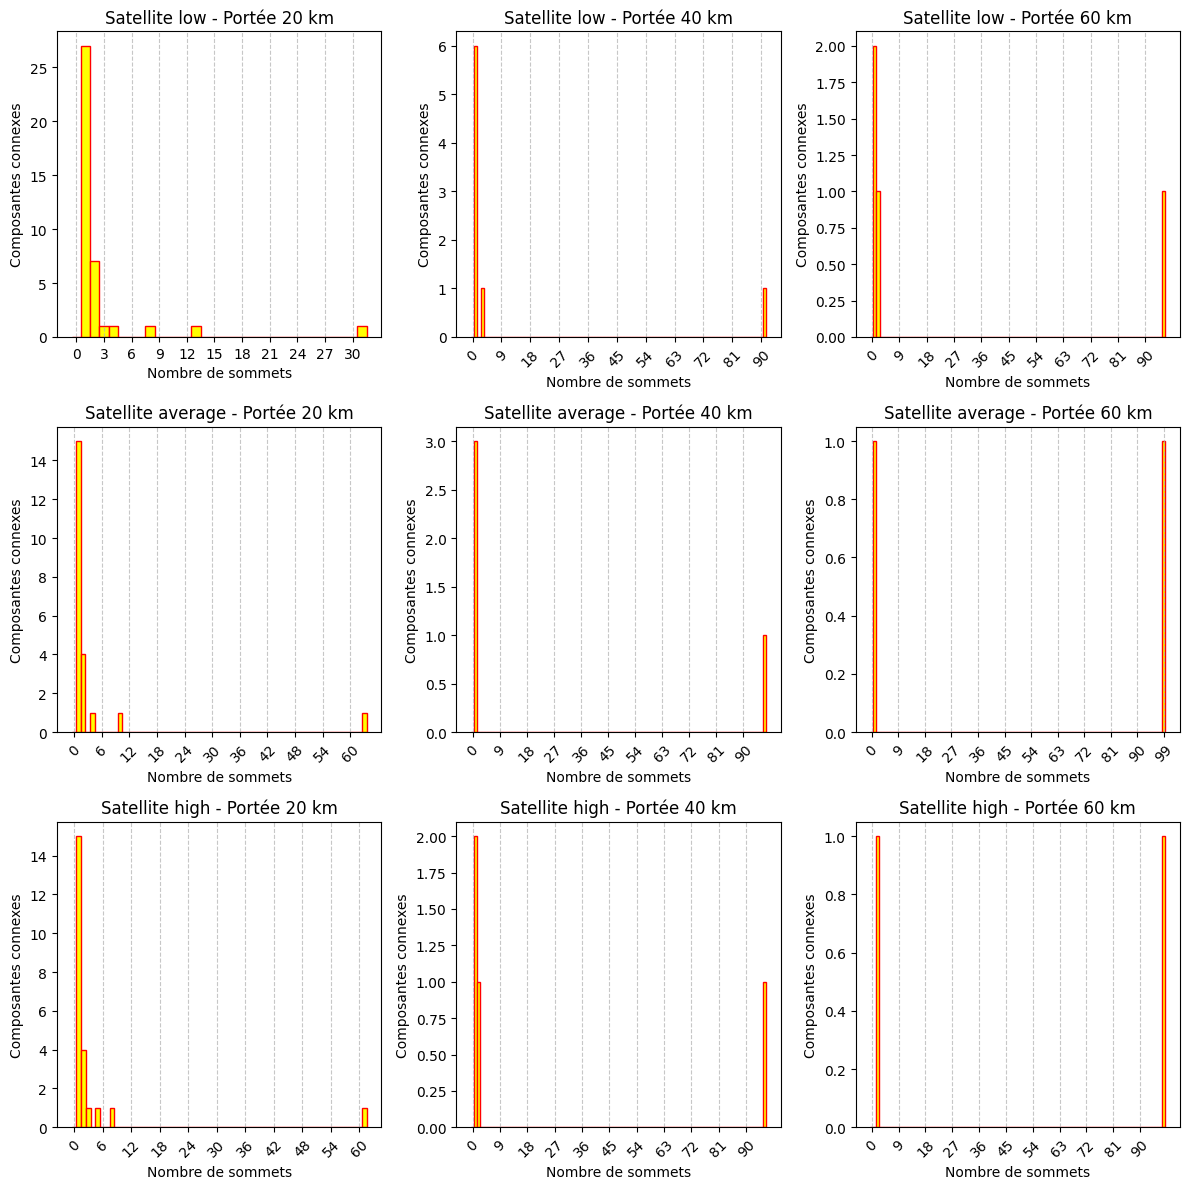

In [8]:
#AFFICHAGE DE LA DISTRIBUTION DE COMPOSANTE CONNEXE( LE NOMBRE DE COMPOSANTES CONNEXES EN FONCTION DE LEUR ORDRE)
def all_connectedComponent_density():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            with open(path, 'r') as fichier:
                contenu = csv.DictReader(fichier)
                ligne = list(contenu)

            G = Graph(ligne, portee)
            component_sizes = [len(comp) for comp in nx.connected_components(G)]
            max_component_size = max(component_sizes)
            bins = range(max_component_size + 2)
            
            ax.hist(component_sizes, bins=bins, color='yellow', edgecolor='red', align='left')

            # Calcul d'un espacement adaptatif pour les étiquettes
            if max_component_size > 20:
                # Si beaucoup de valeurs, on affiche un nombre réduit d'étiquettes
                step = max(1, max_component_size // 10)  # Divise l'axe en ~10 étiquettes
                xticks = range(0, max_component_size + 1, step)
            else:
                # Si peu de valeurs, on peut toutes les afficher
                xticks = range(0, max_component_size + 1)

            ax.set_xticks(xticks)  
            plt.setp(ax.get_xticklabels(), rotation=45 if max_component_size > 60 else 0) # Rotation si beaucoup de valeurs
            ax.set_xlabel('Nombre de sommets')
            ax.set_ylabel('Composantes connexes')
            ax.set_title(f'{title} - Portée {portee} km')
            ax.grid(axis='x', linestyle='--', alpha=0.7)  # Ajout d'une grille pour faciliter la lecture

    plt.tight_layout()
    plt.show()

all_connectedComponent_density()
    

#### DISTRIBUTION DE COURTS CHEMINS

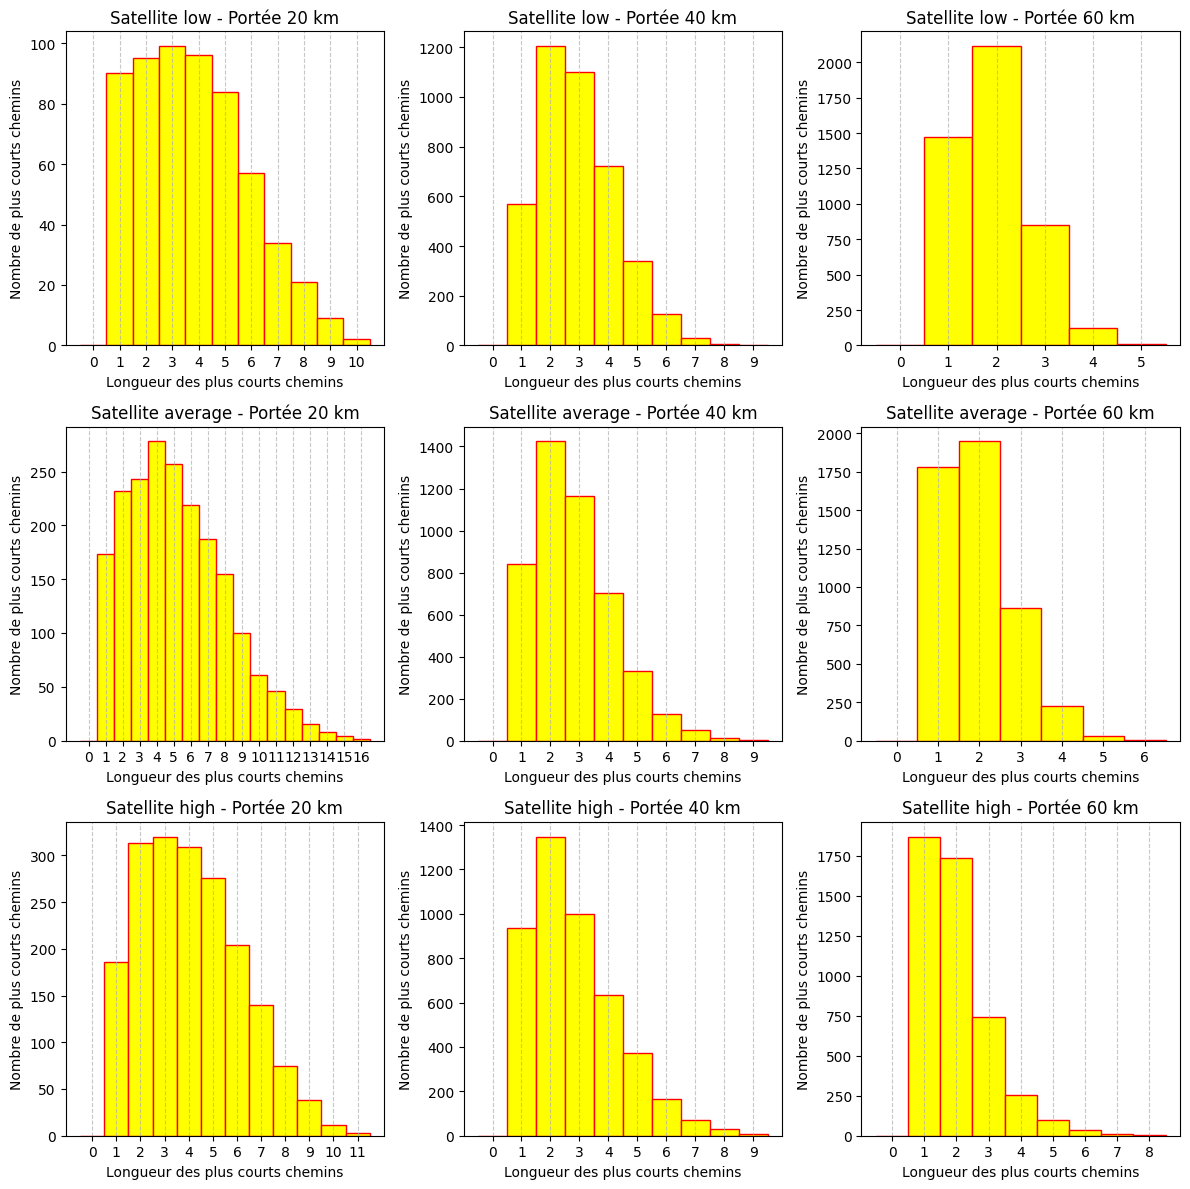

In [9]:
#DISTRIBUTION DES COURTS CHEMINS (LE NOMBRE DE COURTS CHEMIN EN FONCTION DE LEUR LONGUEUR)
def all_shortestPath_density():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [20, 40, 60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(len(tabs), len(portees), figsize=(12, 12))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]

        for j in range(len(portees)):
            portee = portees[j]
            ax = axes[i, j]  

            with open(path, 'r') as fichier:
                contenu = csv.DictReader(fichier)
                ligne = list(contenu)

            G = Graph(ligne, portee)
            shortest_path_length = dict(nx.shortest_path_length(G))
            
            # Récupère toutes les distances dans une liste
            dist = []
            for k in range(0, len(shortest_path_length)):
                key = shortest_path_length[str(k)].keys()
                for l in key:
                    if int(l) > k:
                        dist.append(shortest_path_length[str(k)][str(l)])  
                        
            # Histogramme des plus courts chemins
            max_path_length = max(dist)
            bins = range(max_path_length + 2)
            
            ax.hist(dist, bins=bins, color='yellow', edgecolor='red', align='left')
            ax.set_xticks(range(0, max_path_length + 1))
            ax.set_xlabel('Longueur des plus courts chemins')
            ax.set_ylabel('Nombre de plus courts chemins')
            ax.set_title(f'{title} - Portée {portee} km')
            ax.grid(axis='x', linestyle='--', alpha=0.7)  # Ajout d'une grille pour faciliter la lecture

    plt.tight_layout()
    plt.show()

all_shortestPath_density()
    

#### PARTIE 3 : DISTRIBUTION DE COURTS CHEMINS

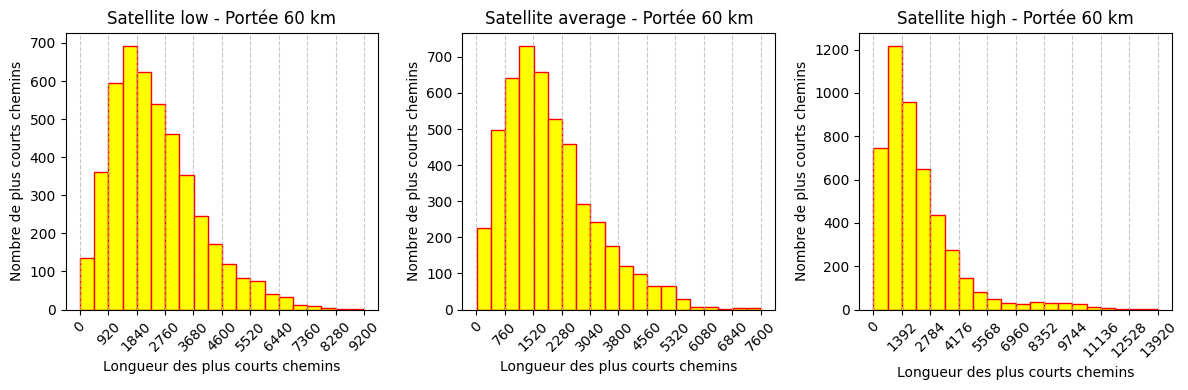

In [10]:
# PARTIE 3 : Cas particulier des plus courts chemins pour les graphes pondérés: 
def all_shortestPath_densityWeight():
    tabs = ['Configuration/topology_low.csv', 'Configuration/topology_avg.csv', 'Configuration/topology_high.csv']
    portees = [60]
    titles = ['Satellite low', 'Satellite average', 'Satellite high']
    
    fig, axes = plt.subplots(1, len(tabs), figsize=(12, 4))

    for i in range(len(tabs)):
        path = tabs[i]
        title = titles[i]
        
        ax = axes[i]

        with open(path, 'r') as fichier:
            contenu = csv.DictReader(fichier)
            ligne = list(contenu)

        GW60 = GraphWeight60k(ligne)
        shortest_path_lengthW60 = dict(nx.all_pairs_dijkstra_path_length(GW60, weight='weight'))
        
    
        # Récupère toutes les distances dans une liste
        dist = []
        for k in range(0, len(shortest_path_lengthW60)):
            key = shortest_path_lengthW60[str(k)].keys()
            for l in key:
                if int(l) > k:
                    dist.append(shortest_path_lengthW60[str(k)][str(l)])  

        # Histogramme des plus courts chemins
        max_path_length = max(dist)
        bins = min(20, max_path_length)  # Limite le nombre de barres à 20 maximum pour la lisibilité
        ax.hist(dist, bins=bins, color='yellow', edgecolor='red', align='mid')

        # Configuration des axes
        ax.set_xlabel('Longueur des plus courts chemins')
        ax.set_ylabel('Nombre de plus courts chemins')
        ax.set_title(f'{title} - Portée {portees[0]} km')

        # Ajout de ticks propres
        ax.set_xticks(range(0, int(max_path_length) + 1, max(1, int(max_path_length) // 10)))
        ax.tick_params(axis='x', rotation=45)
        ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


all_shortestPath_densityWeight()

#### PARTIE 3: MATRICE DES PLUS COURTS CHEMINS (graphes ponderés)

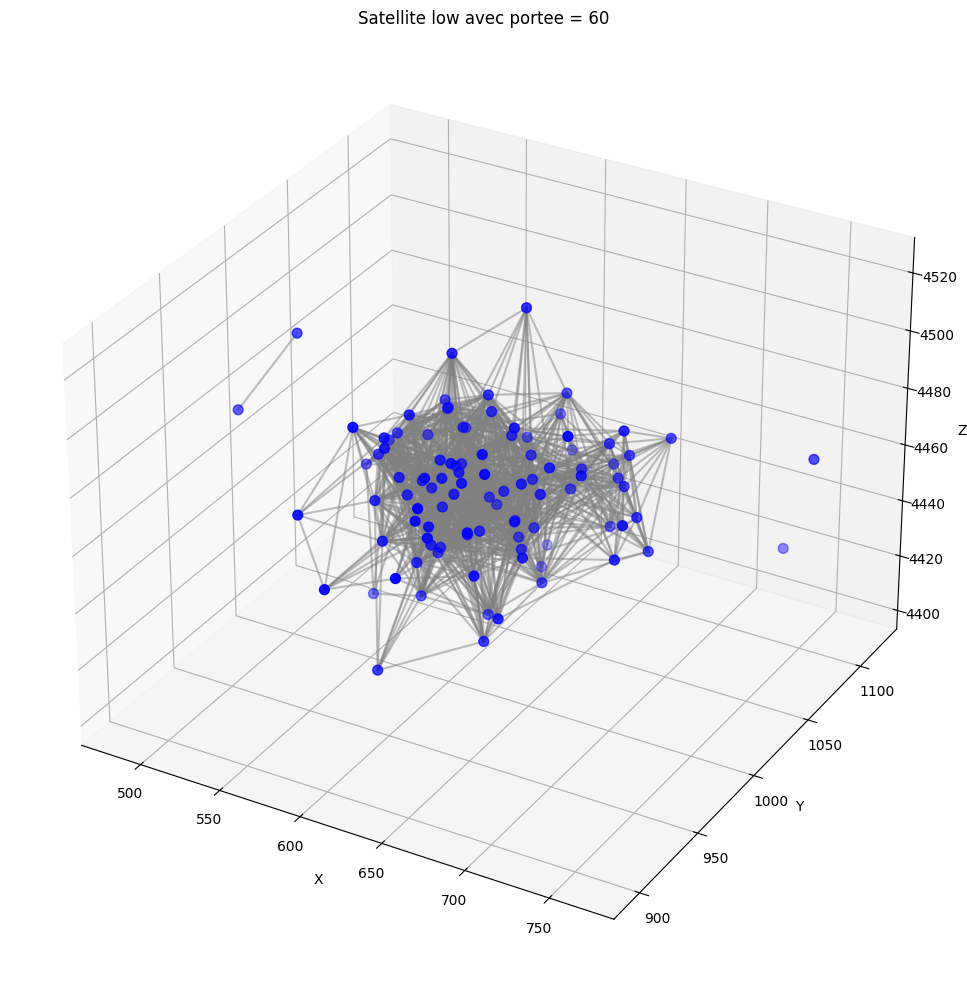

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1471
Degrée moyen du graph: 29.42
Coefficient de clustering moyen: 0.6723798097803951
Nombre de composantes connexes: 4
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4561
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 4561

Matrice des longueurs des chemins les plus courts:
 
              0            1            2  3            4            5  \
0           0.0  3465.527493   3032.38809  ∞  3850.602626  3150.034695   
1   3465.527493          0.0  2086.790992  ∞  4562.244924   919.244715   
10  5620.566395  2590.199352   3053.43134  ∞  6404.374653    2470.5317   
11   3276.64615  1433.999971    652.79102  ∞  4003.734334   514.755257   
12  1542.948593  2756.129626  2171.004419  ∞   2898.92226  2288.651024   
..          ...          ...          .

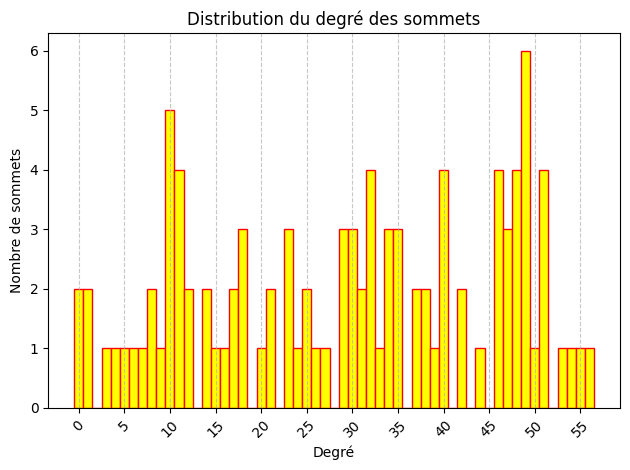

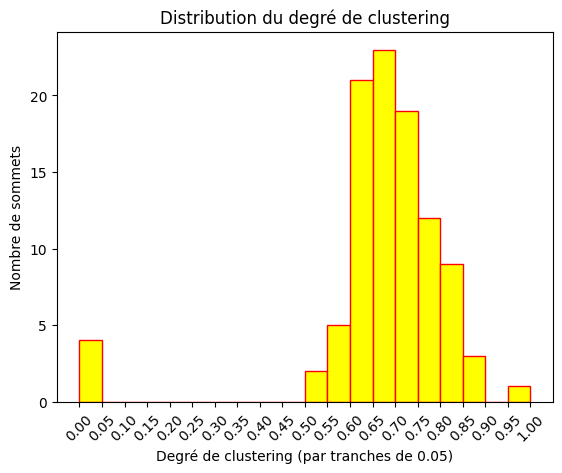

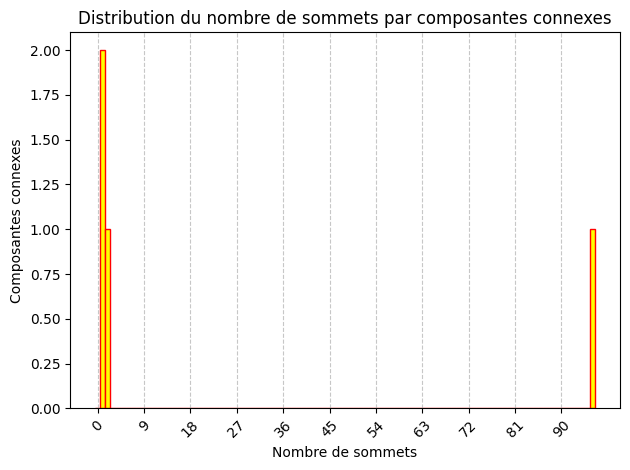

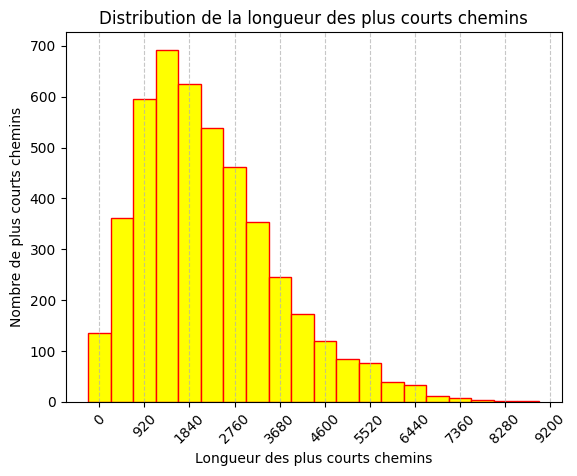

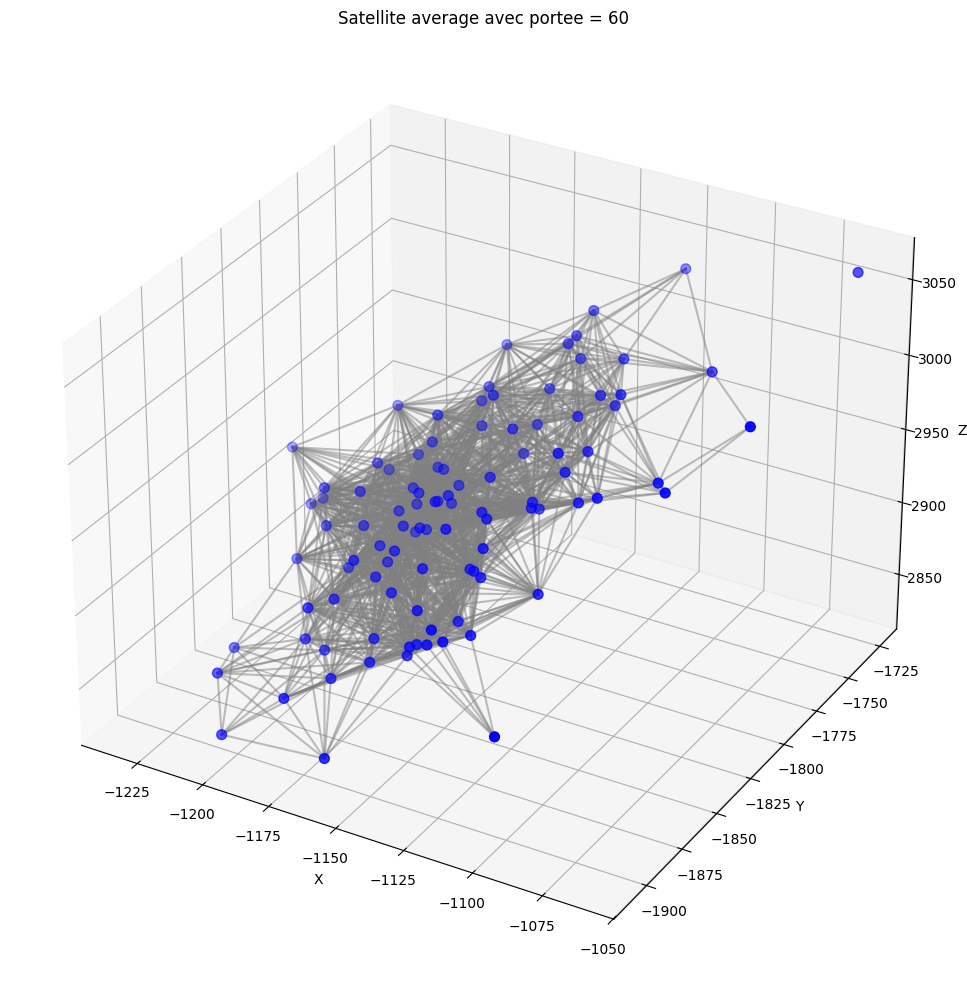

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1782
Degrée moyen du graph: 35.64
Coefficient de clustering moyen: 0.728028562269481
Nombre de composantes connexes: 2
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4851
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 4851

Matrice des longueurs des chemins les plus courts:
 
              0            1            2            3            4  \
0           0.0  1437.304248  1227.427103  1741.283873  3202.050365   
1   1437.304248          0.0   1167.92738  1293.927612  2180.426805   
10  3125.344705  2033.268344  2078.850873  3152.543528  1731.407973   
11  1259.691825   177.612423   990.314957  1181.693527  2051.039604   
12  1032.689344  1628.844031  1034.243751  1932.823656  3172.512057   
..          ...          ...          ...          ...    

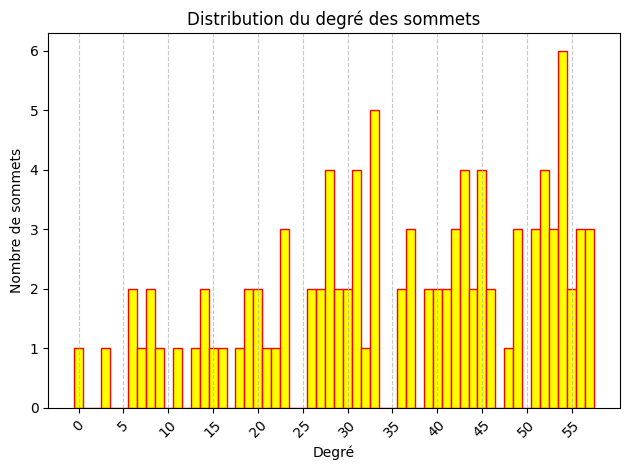

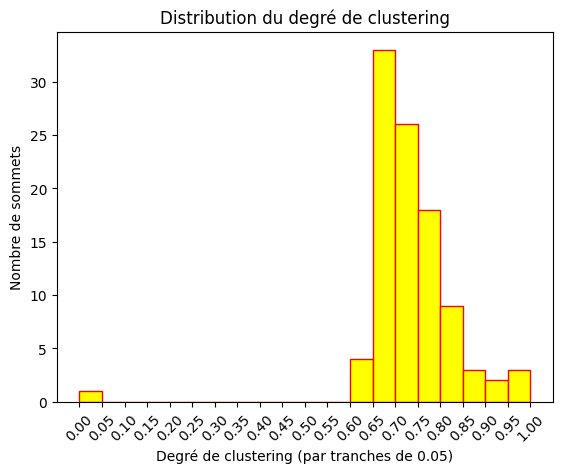

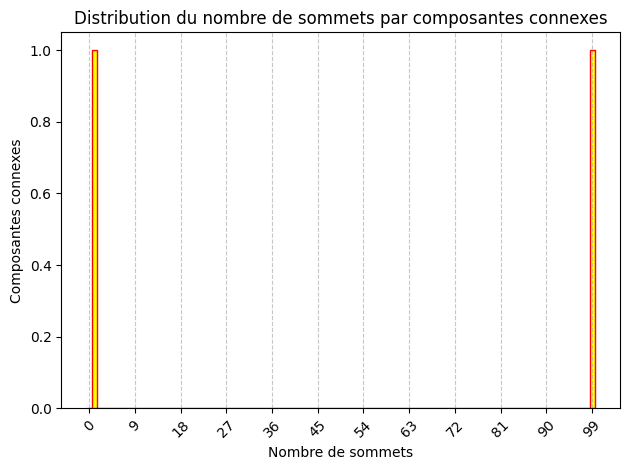

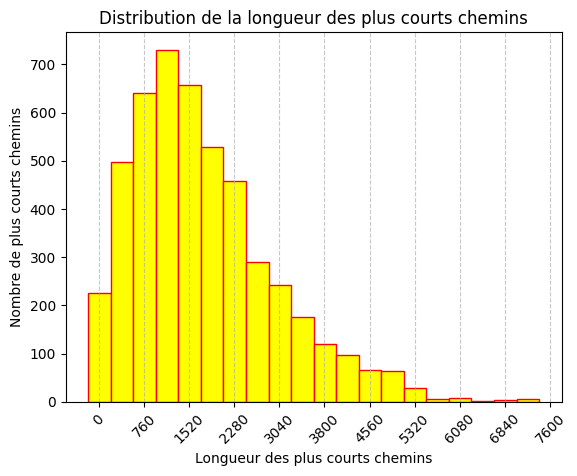

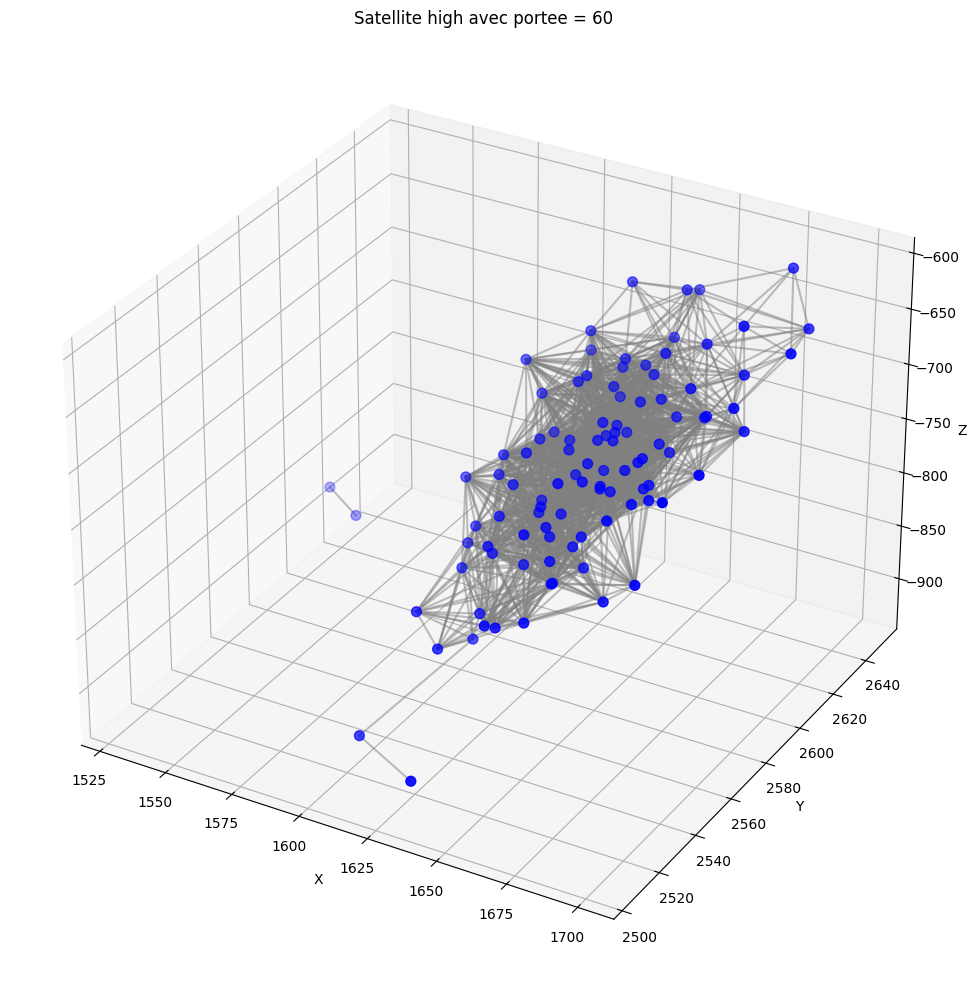

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1870
Degrée moyen du graph: 37.4
Coefficient de clustering moyen: 0.7280564598604691
Nombre de composantes connexes: 2
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4754
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 4754

Matrice des longueurs des chemins les plus courts:
 
              0            1            2            3            4  \
0           0.0  1027.872322  2997.569745   4557.81393  3174.416548   
1   1027.872322          0.0  3018.701716  3804.876479   2186.39118   
10  1862.345931  1699.091187  1411.265016  5503.967666  3885.482367   
11  1558.970599  1664.303027  1493.911261  5411.458138  3850.694207   
12    860.25574    236.20718  3098.802875  3971.684469  2378.044145   
..          ...          ...          ...          ...    

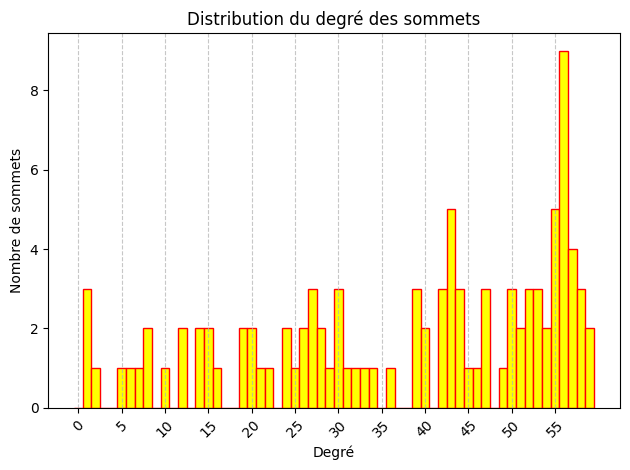

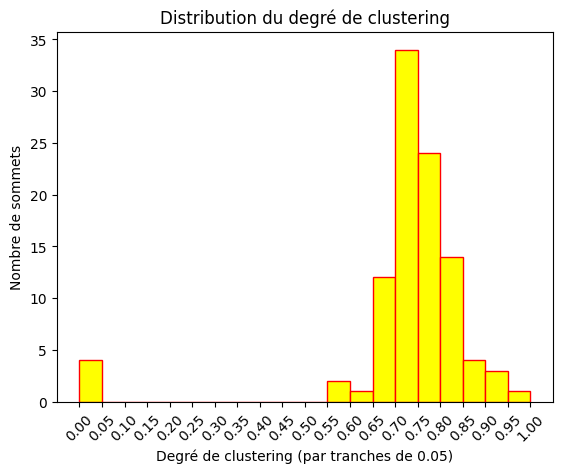

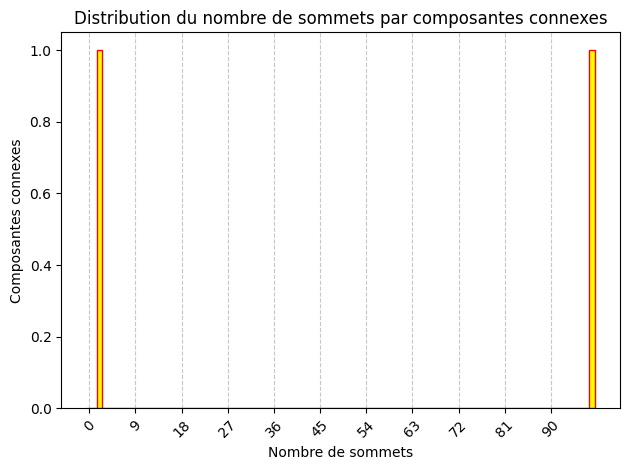

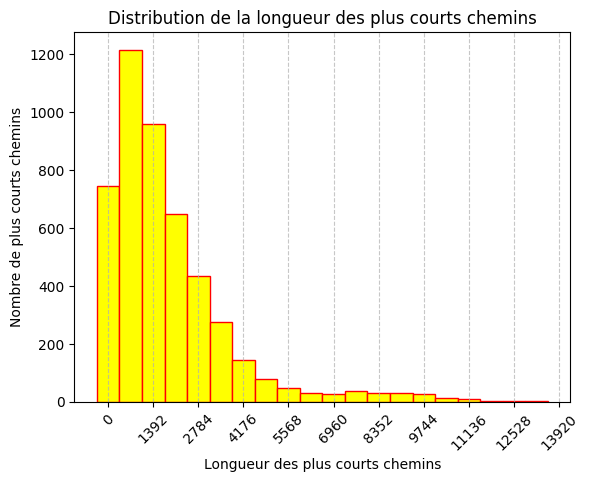

In [11]:
#Par défaut, les histogrammes ne seront pas affichés. 
#Pour les afficher, il suffit de remplacer le paramètre booleen à True. Si contraire, mettre à False

analyze_all_exercice3(True) #ponderation prises en compte

### AFFICHE DES CARACTERISTIQUES SELON LA DENSITE ET LA PORTEE : GRAPHES NON PONDERES

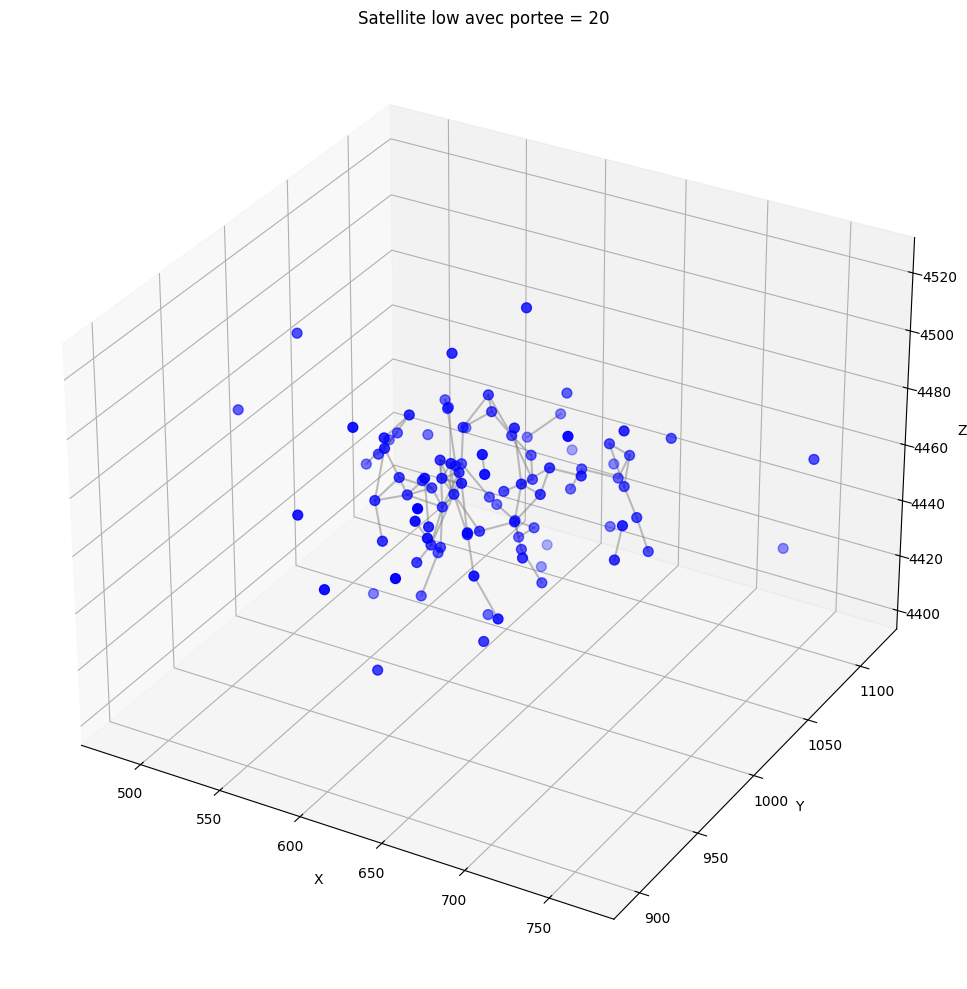

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 90
Degrée moyen du graph: 1.8
Coefficient de clustering moyen: 0.22607936507936507
Nombre de composantes connexes: 39
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 587
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 1045

Matrice des longueurs des chemins les plus courts:
 
      0    1  2  3  4    5  6  7    8  9  ... 90 91   92   93 94 95 96 97 98  \
0   0.0    ∞  ∞  ∞  ∞    ∞  ∞  ∞    ∞  ∞  ...  ∞  ∞    ∞    ∞  ∞  ∞  ∞  ∞  ∞   
1     ∞  0.0  ∞  ∞  ∞  3.0  ∞  ∞  4.0  ∞  ...  ∞  ∞    ∞    ∞  ∞  ∞  ∞  ∞  ∞   
15    ∞  1.0  ∞  ∞  ∞  4.0  ∞  ∞  5.0  ∞  ...  ∞  ∞    ∞    ∞  ∞  ∞  ∞  ∞  ∞   
18    ∞  1.0  ∞  ∞  ∞  2.0  ∞  ∞  3.0  ∞  ...  ∞  ∞    ∞    ∞  ∞  ∞  ∞  ∞  ∞   
74    ∞  1.0  ∞  ∞  ∞  4.0  ∞  ∞  5.0  ∞  ...  ∞  ∞    ∞    ∞  ∞  ∞  ∞  ∞  ∞   
..  ..

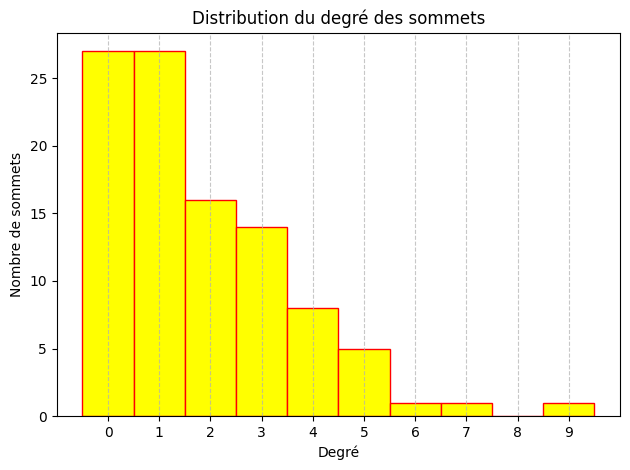

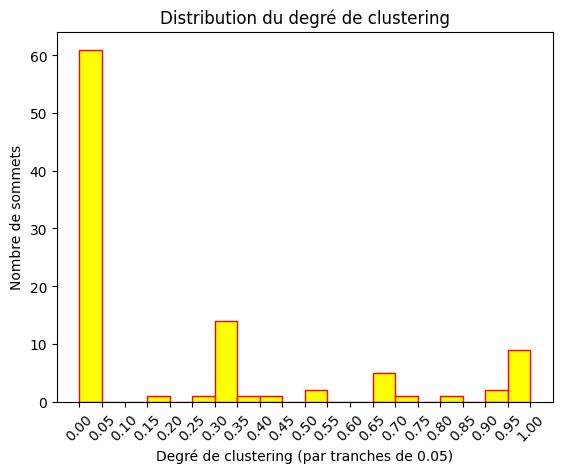

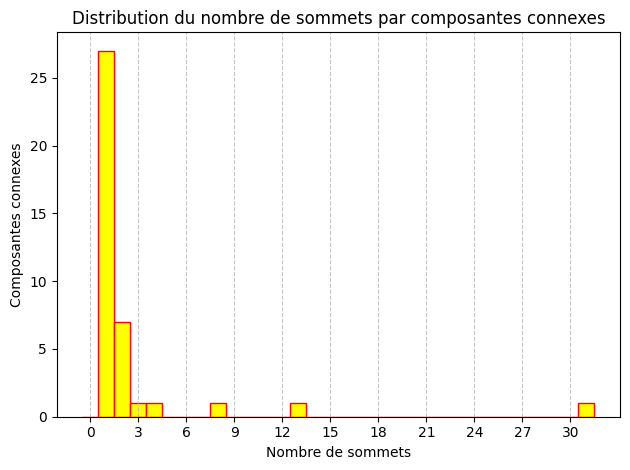

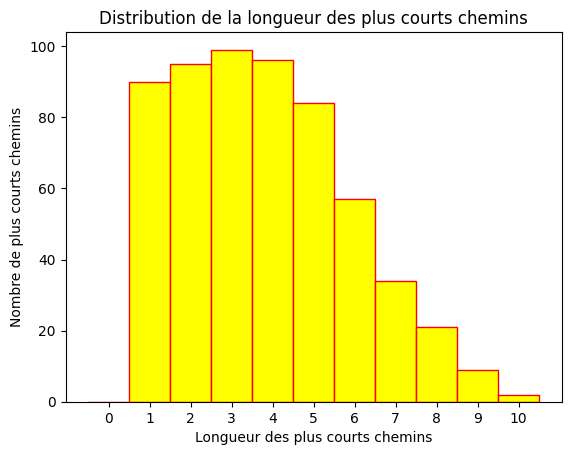

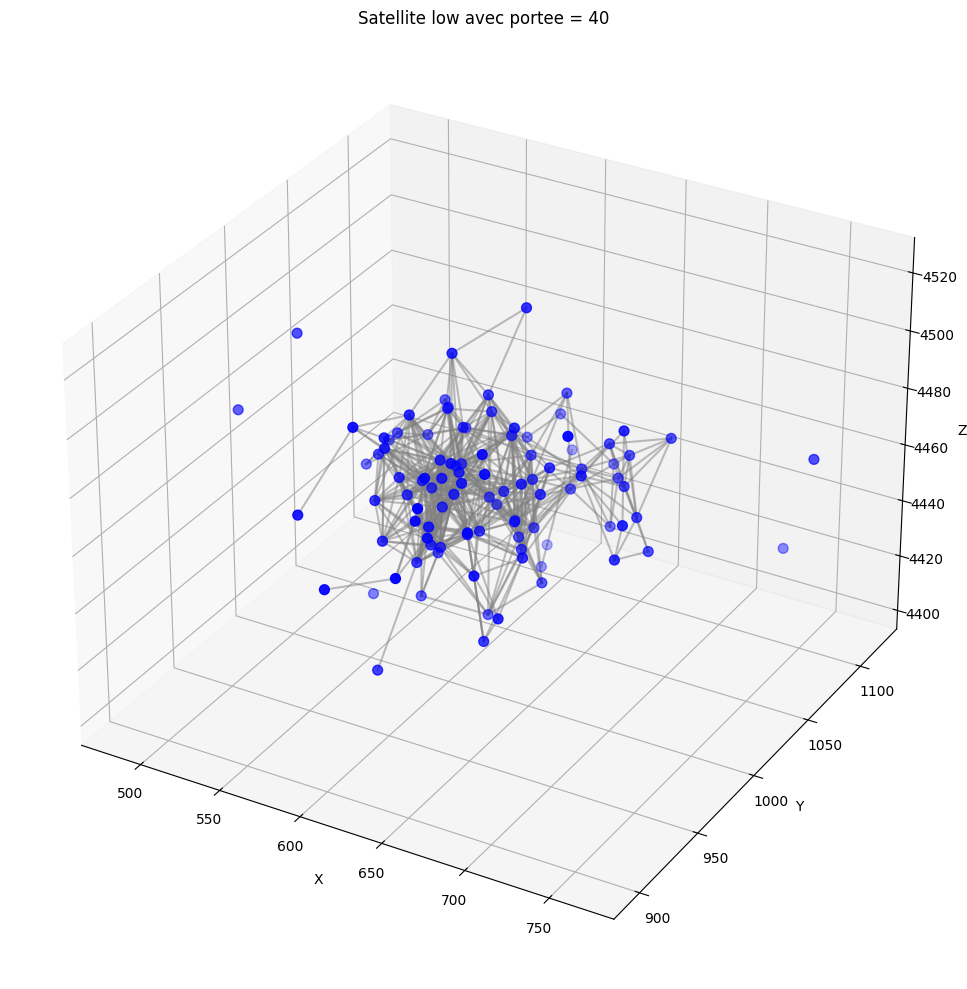

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 571
Degrée moyen du graph: 11.42
Coefficient de clustering moyen: 0.5204658854961058
Nombre de composantes connexes: 8
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4098
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 55731

Matrice des longueurs des chemins les plus courts:
 
      0    1    2  3  4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  5.0  4.0  ∞  ∞  4.0  4.0  3.0  4.0  3.0  ...  4.0  5.0    ∞  3.0   
21  1.0  6.0  5.0  ∞  ∞  5.0  5.0  4.0  5.0  4.0  ...  5.0  6.0    ∞  4.0   
32  1.0  4.0  4.0  ∞  ∞  4.0  3.0  3.0  3.0  2.0  ...  3.0  5.0    ∞  2.0   
65  1.0  4.0  3.0  ∞  ∞  3.0  3.0  2.0  3.0  2.0  ...  3.0  4.0    ∞  2.0   
75  1.0  4.0  4.0  ∞  ∞  3.0  3.0  2.0  3.0  2.0  ...  3.0  4.0    ∞  2.0   
..  ...  ...  ... .. 

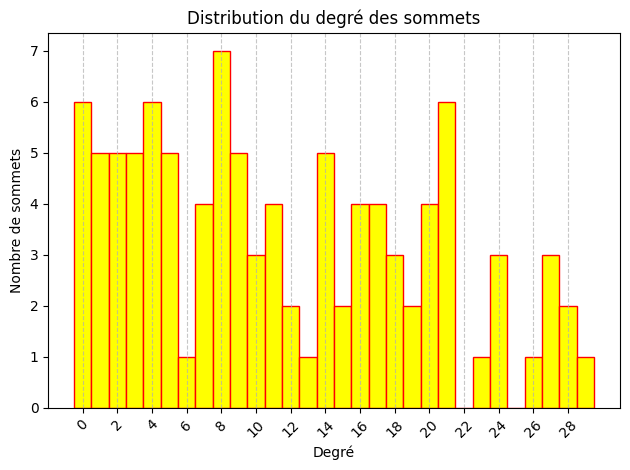

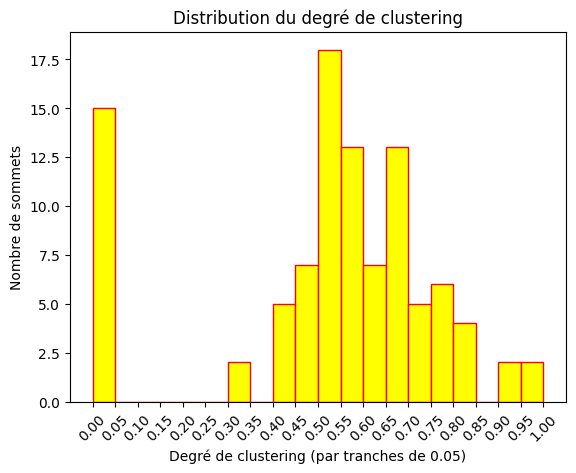

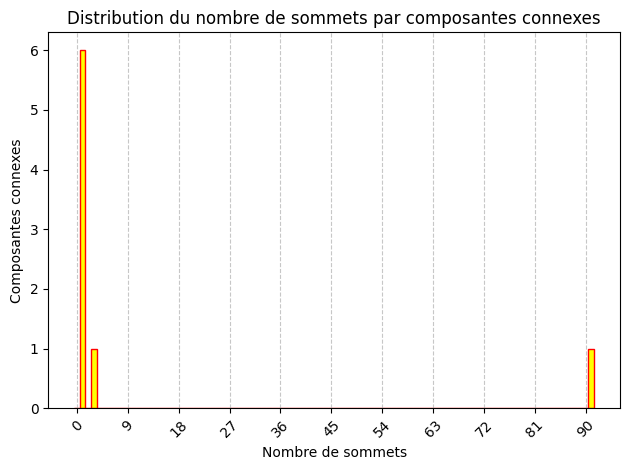

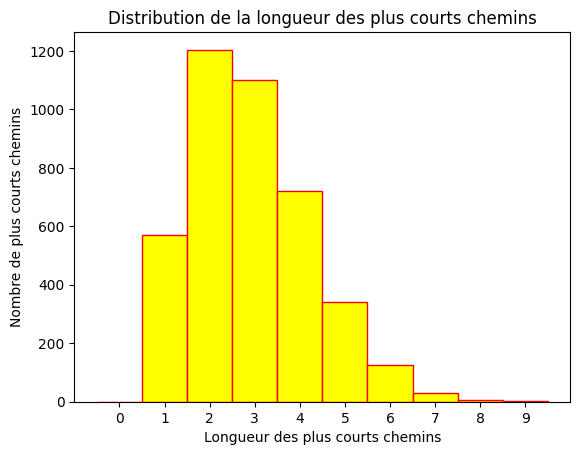

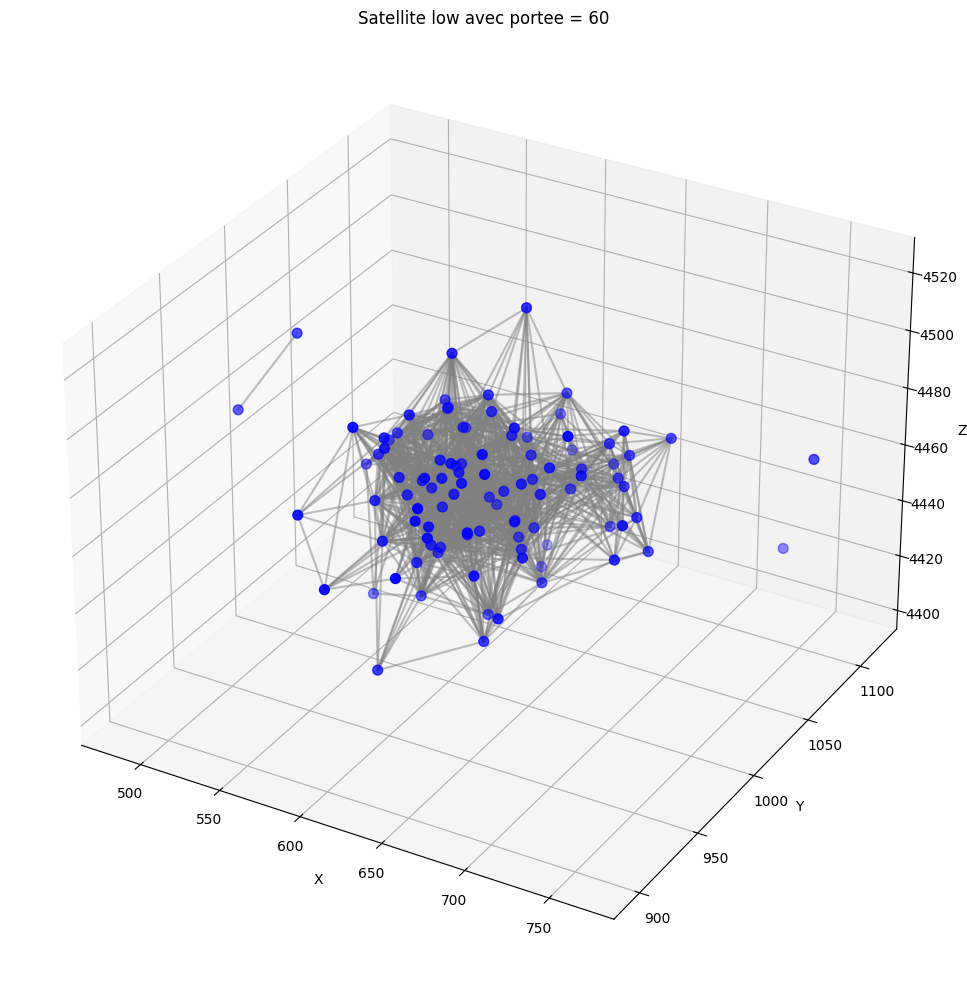

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1471
Degrée moyen du graph: 29.42
Coefficient de clustering moyen: 0.6723798097803951
Nombre de composantes connexes: 4
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4561
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 90539

Matrice des longueurs des chemins les plus courts:
 
      0    1    2    3    4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  3.0  3.0    ∞  2.0  3.0  2.0  2.0  3.0  2.0  ...  2.0  3.0    ∞  2.0   
12  1.0  3.0  2.0    ∞  2.0  2.0  2.0  1.0  2.0  1.0  ...  2.0  2.0    ∞  2.0   
21  1.0  3.0  3.0    ∞  3.0  3.0  2.0  2.0  3.0  2.0  ...  2.0  3.0    ∞  1.0   
32  1.0  3.0  3.0    ∞  2.0  3.0  2.0  2.0  3.0  2.0  ...  2.0  3.0    ∞  1.0   
57  1.0  2.0  2.0    ∞  2.0  2.0  1.0  1.0  2.0  1.0  ...  1.0  2.0    ∞  1.0

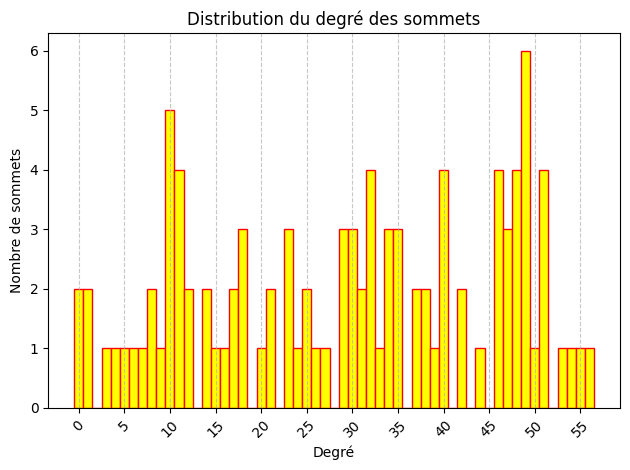

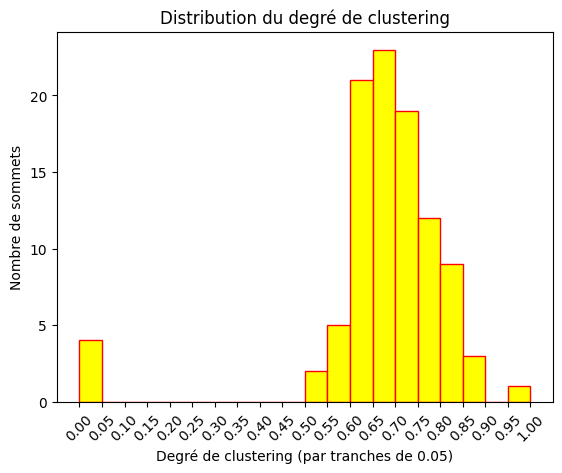

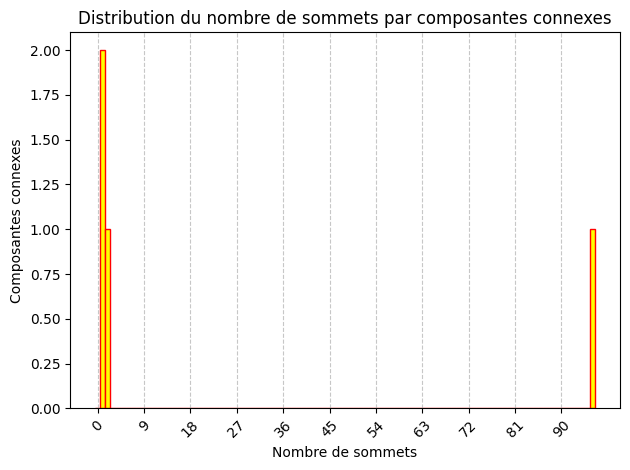

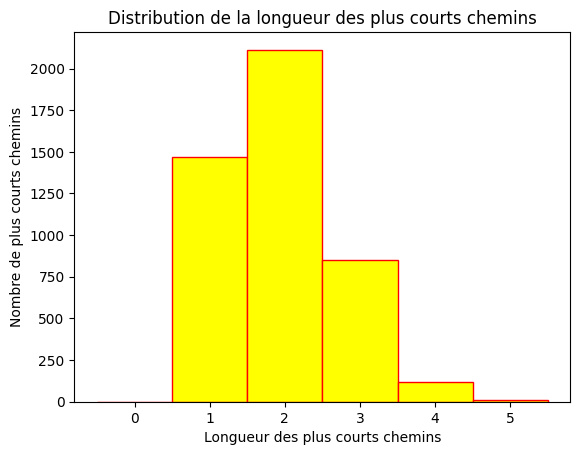

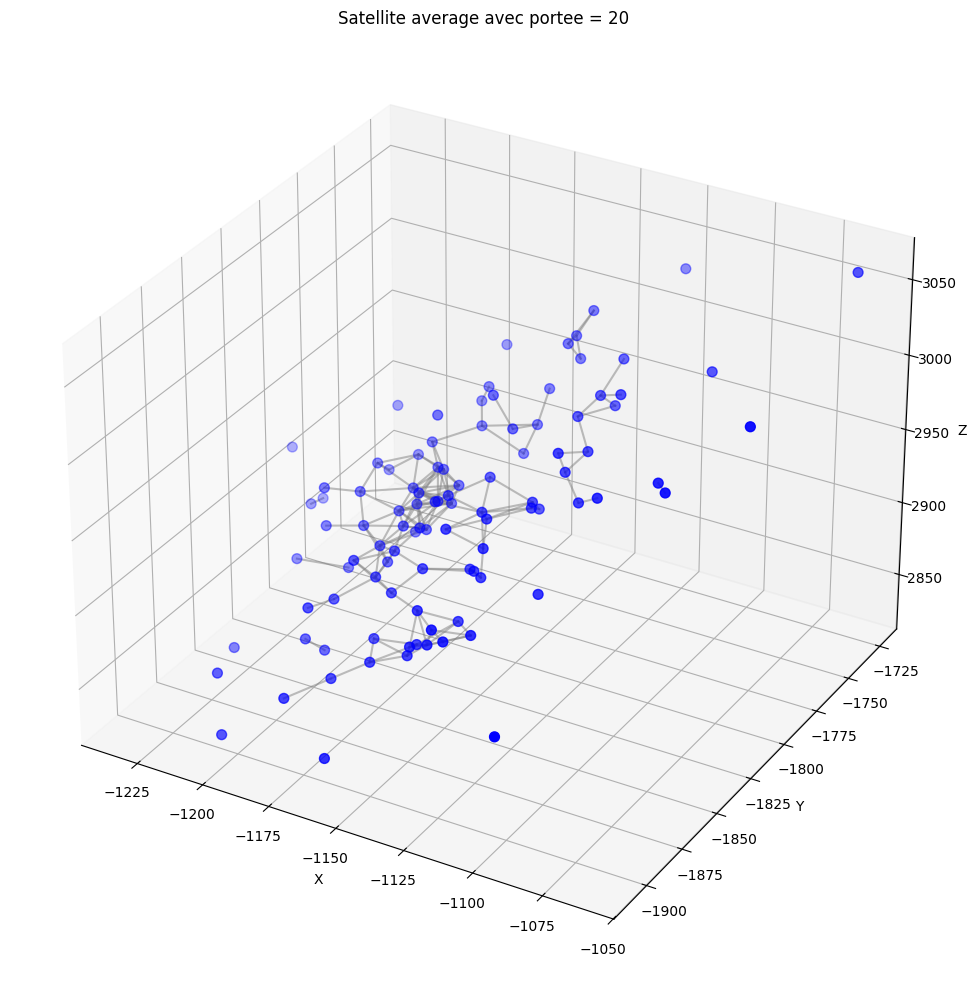

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 173
Degrée moyen du graph: 3.46
Coefficient de clustering moyen: 0.36371406371406373
Nombre de composantes connexes: 22
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 2008
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 50210

Matrice des longueurs des chemins les plus courts:
 
      0    1    2  3  4    5    6    7    8    9  ...   90 91   92   93 94  \
0   0.0  6.0  5.0  ∞  ∞  5.0  3.0  7.0  8.0  7.0  ...  2.0  ∞    ∞  5.0  ∞   
22  1.0  5.0  4.0  ∞  ∞  4.0  2.0  6.0  7.0  6.0  ...  1.0  ∞    ∞  4.0  ∞   
90  2.0  4.0  3.0  ∞  ∞  3.0  1.0  5.0  6.0  5.0  ...  0.0  ∞    ∞  3.0  ∞   
6   3.0  5.0  2.0  ∞  ∞  4.0  0.0  6.0  7.0  4.0  ...  1.0  ∞    ∞  4.0  ∞   
16  3.0  4.0  3.0  ∞  ∞  3.0  1.0  5.0  6.0  5.0  ...  1.0  ∞    ∞  3.0  ∞   
..  ...  ...  

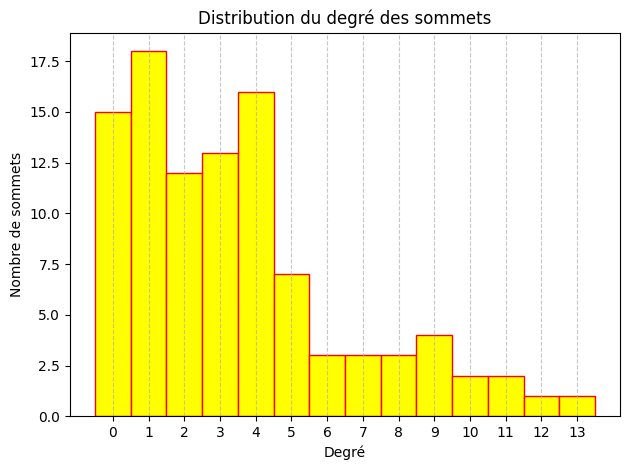

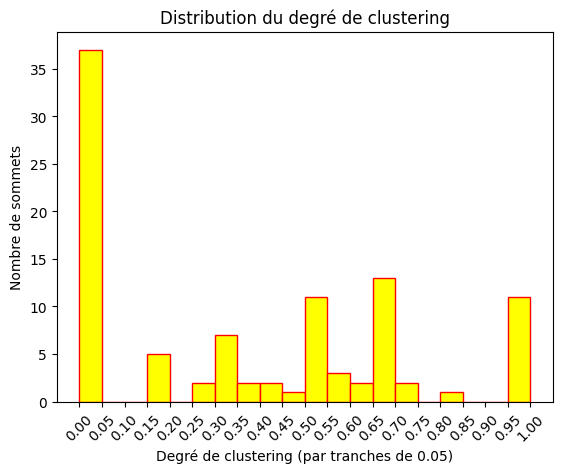

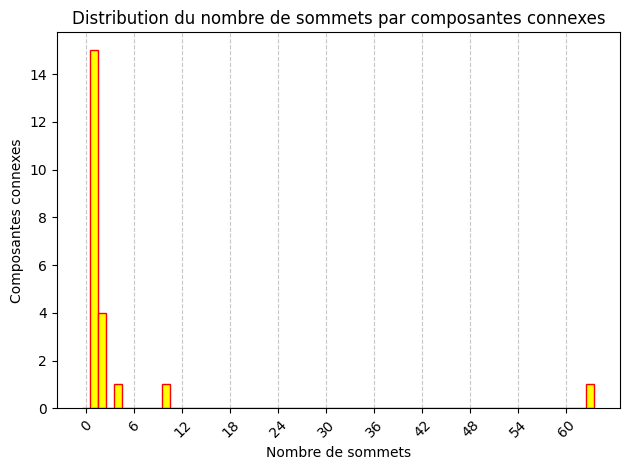

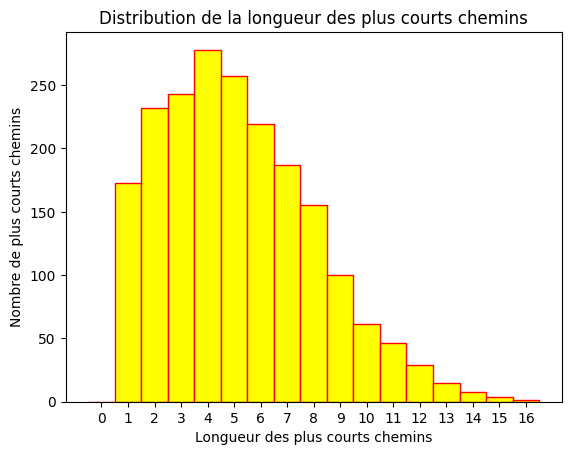

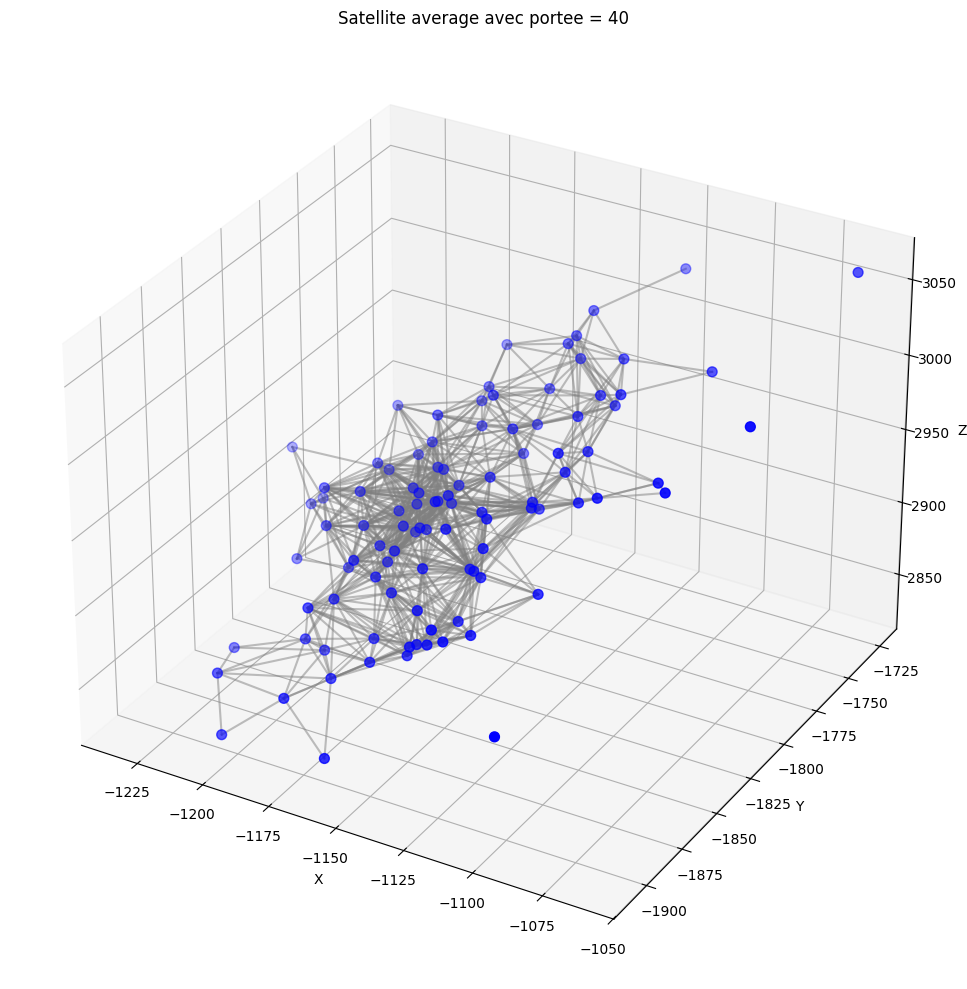

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 842
Degrée moyen du graph: 16.84
Coefficient de clustering moyen: 0.6369519382726182
Nombre de composantes connexes: 4
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4656
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 143892

Matrice des longueurs des chemins les plus courts:
 
      0    1    2    3    4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  3.0  2.0  3.0  4.0  2.0  1.0  3.0  3.0  2.0  ...  1.0  5.0    ∞  2.0   
6   1.0  2.0  1.0  2.0  4.0  2.0  0.0  2.0  3.0  2.0  ...  1.0  4.0    ∞  2.0   
12  1.0  3.0  2.0  3.0  4.0  3.0  1.0  3.0  3.0  2.0  ...  1.0  5.0    ∞  2.0   
16  1.0  2.0  2.0  2.0  4.0  2.0  1.0  2.0  3.0  2.0  ...  1.0  4.0    ∞  1.0   
22  1.0  2.0  2.0  2.0  4.0  2.0  1.0  3.0  3.0  2.0  ...  1.0  5.0    ∞  1.0

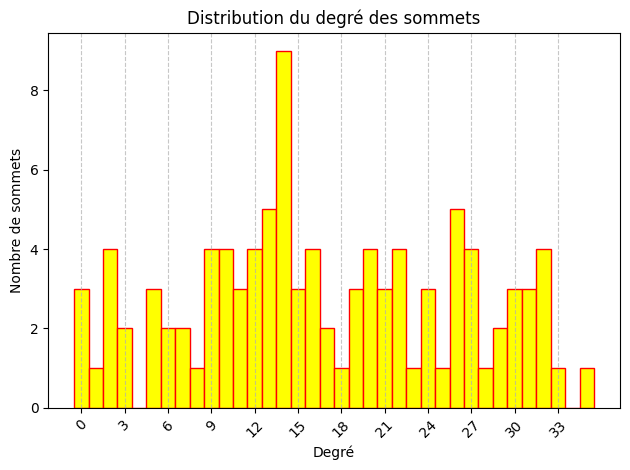

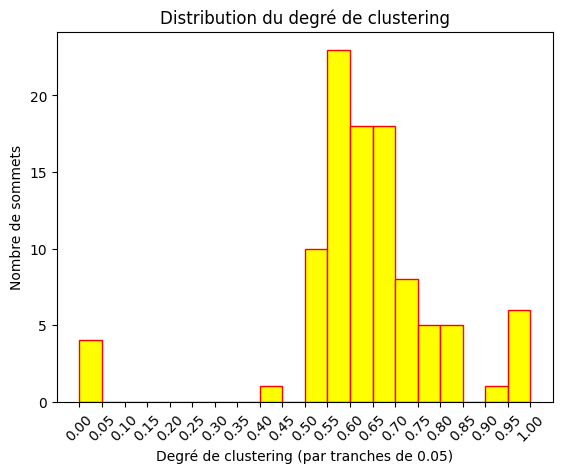

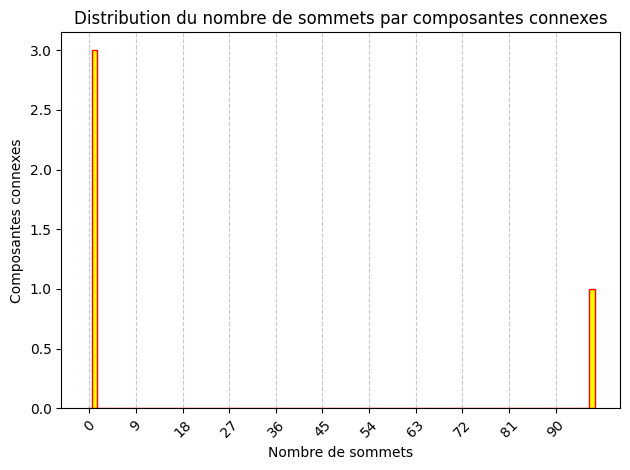

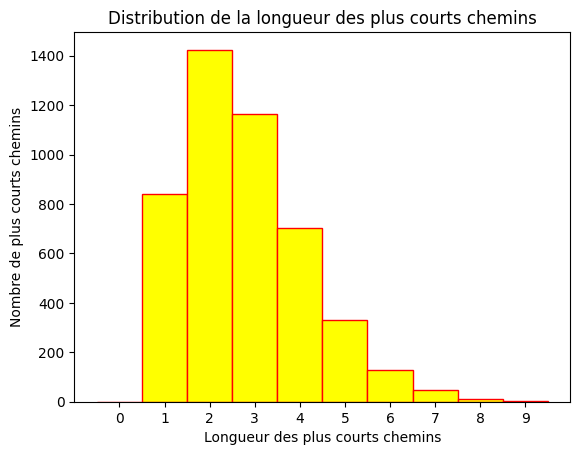

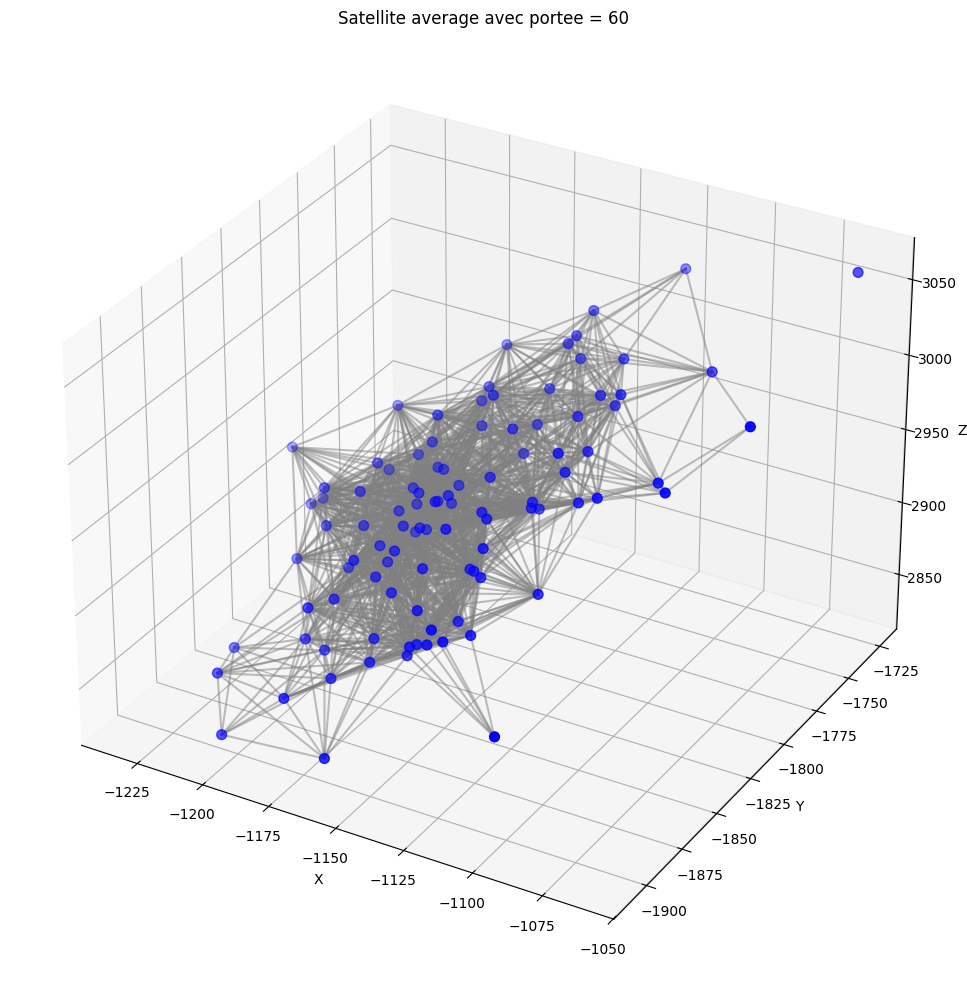

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1782
Degrée moyen du graph: 35.64
Coefficient de clustering moyen: 0.728028562269481
Nombre de composantes connexes: 2
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4851
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 240783

Matrice des longueurs des chemins les plus courts:
 
      0    1    2    3    4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  2.0  1.0  2.0  3.0  2.0  1.0  2.0  2.0  2.0  ...  1.0  3.0    ∞  1.0   
2   1.0  1.0  0.0  2.0  2.0  1.0  1.0  1.0  2.0  1.0  ...  1.0  2.0    ∞  2.0   
6   1.0  2.0  1.0  2.0  3.0  1.0  0.0  2.0  2.0  1.0  ...  1.0  3.0    ∞  1.0   
12  1.0  2.0  1.0  2.0  3.0  2.0  1.0  2.0  2.0  2.0  ...  1.0  3.0    ∞  2.0   
16  1.0  1.0  1.0  1.0  3.0  1.0  1.0  2.0  2.0  1.0  ...  1.0  3.0    ∞  1.0

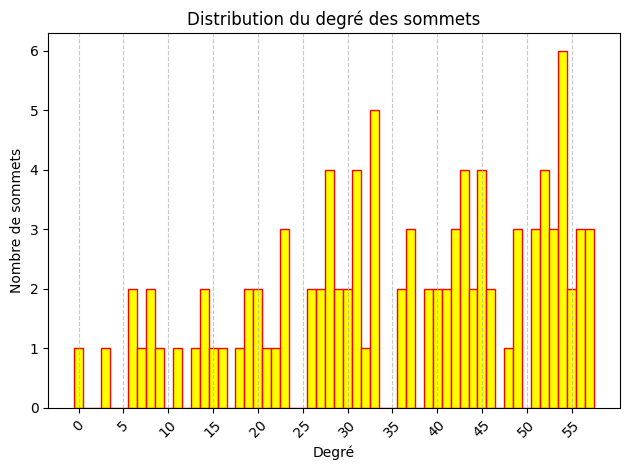

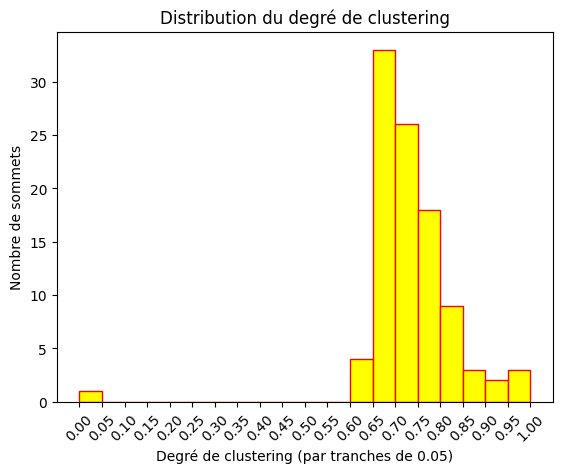

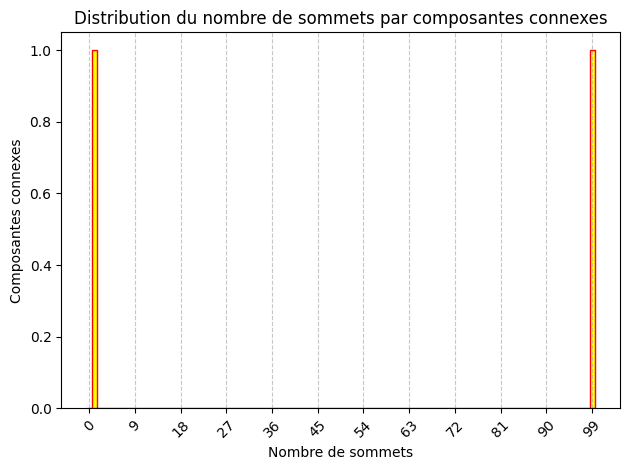

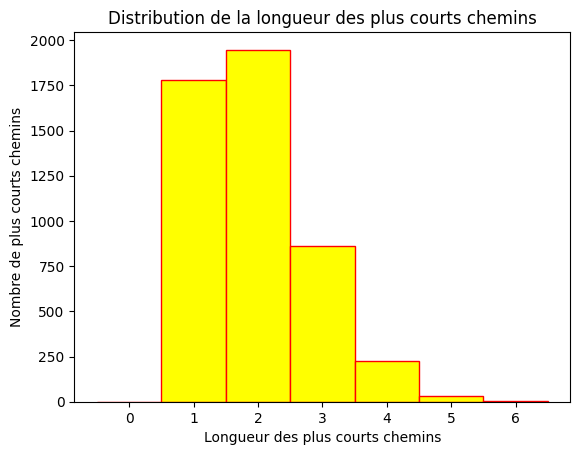

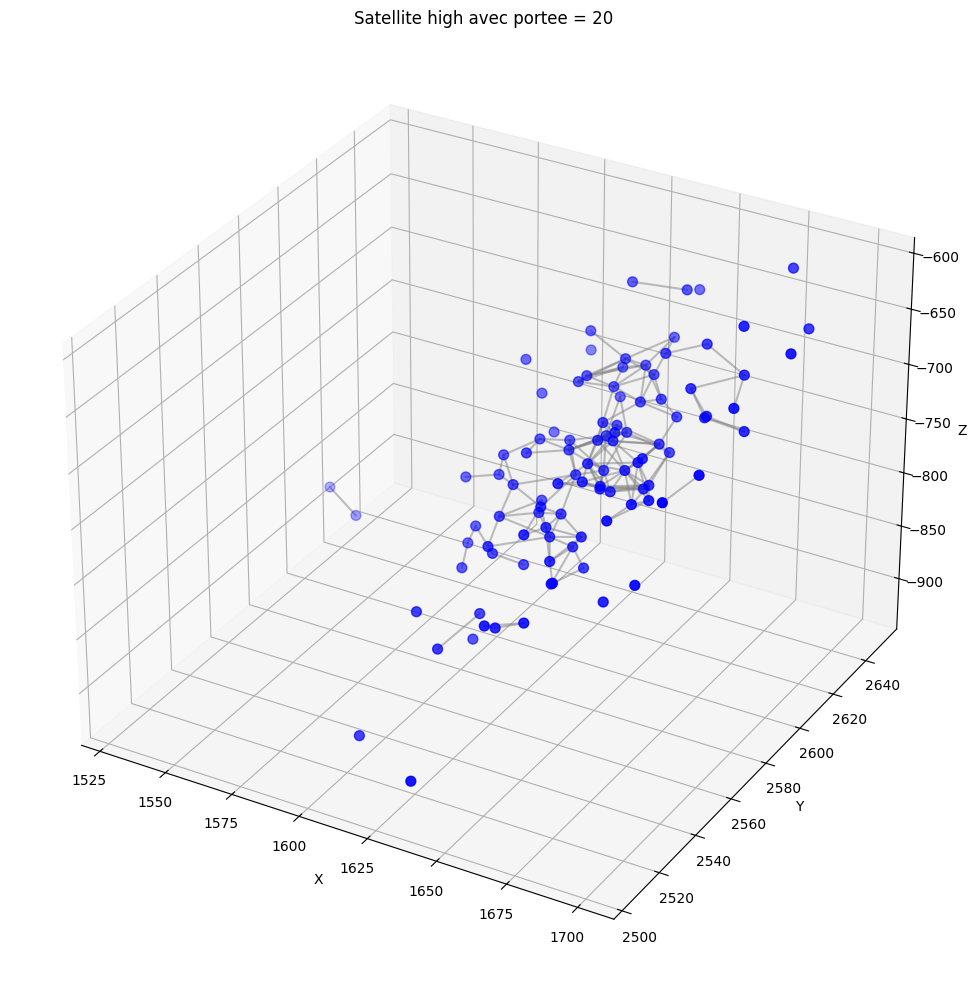

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 186
Degrée moyen du graph: 3.72
Coefficient de clustering moyen: 0.3981209901209901
Nombre de composantes connexes: 23
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 1875
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 9739

Matrice des longueurs des chemins les plus courts:
 
      0    1  2  3  4    5    6    7  8    9  ...   90   91   92   93   94  \
0   0.0  5.0  ∞  ∞  ∞  7.0  5.0  2.0  ∞  6.0  ...  4.0  8.0  3.0    ∞  3.0   
21  1.0  4.0  ∞  ∞  ∞  6.0  4.0  1.0  ∞  5.0  ...  3.0  7.0  2.0    ∞  2.0   
58  1.0  4.0  ∞  ∞  ∞  6.0  4.0  1.0  ∞  5.0  ...  3.0  7.0  2.0    ∞  2.0   
7   2.0  3.0  ∞  ∞  ∞  6.0  3.0  0.0  ∞  4.0  ...  3.0  7.0  2.0    ∞  1.0   
42  2.0  3.0  ∞  ∞  ∞  5.0  3.0  1.0  ∞  4.0  ...  2.0  6.0  1.0    ∞  1.0   
..  ...  ... .. 

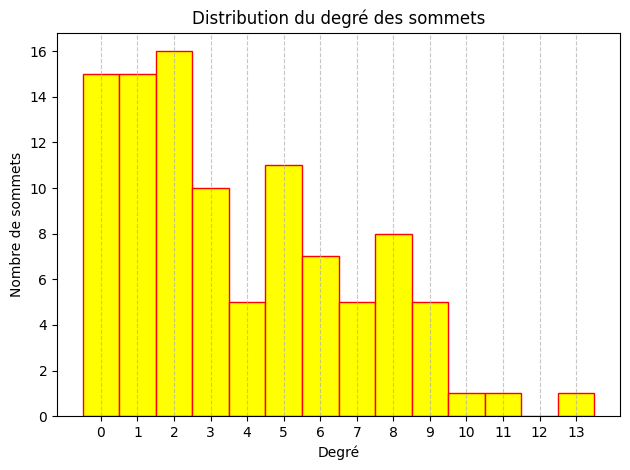

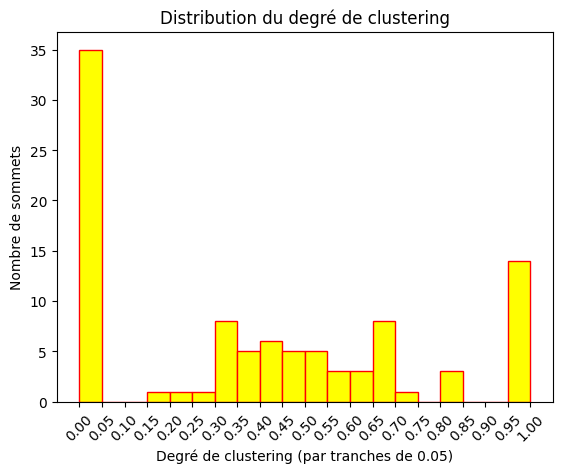

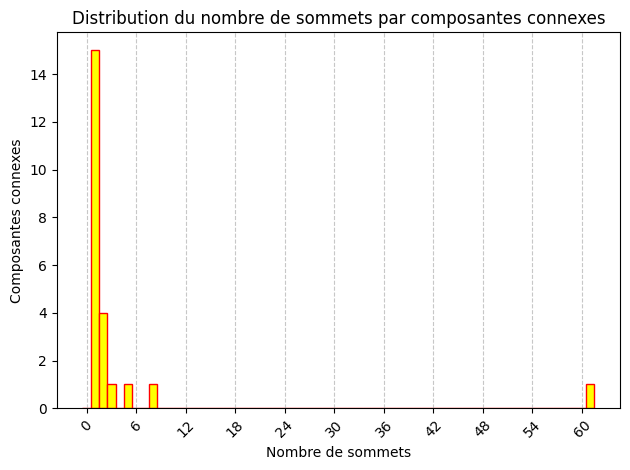

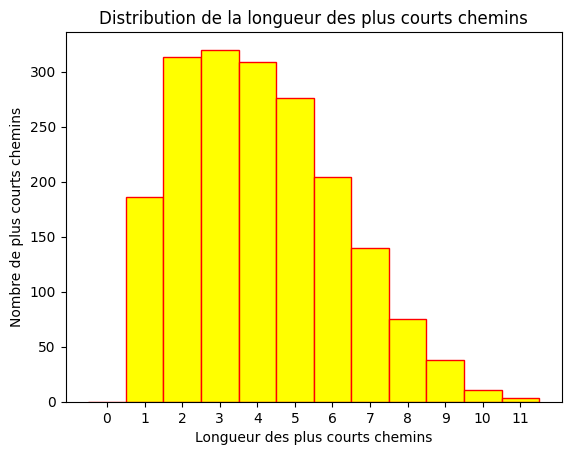

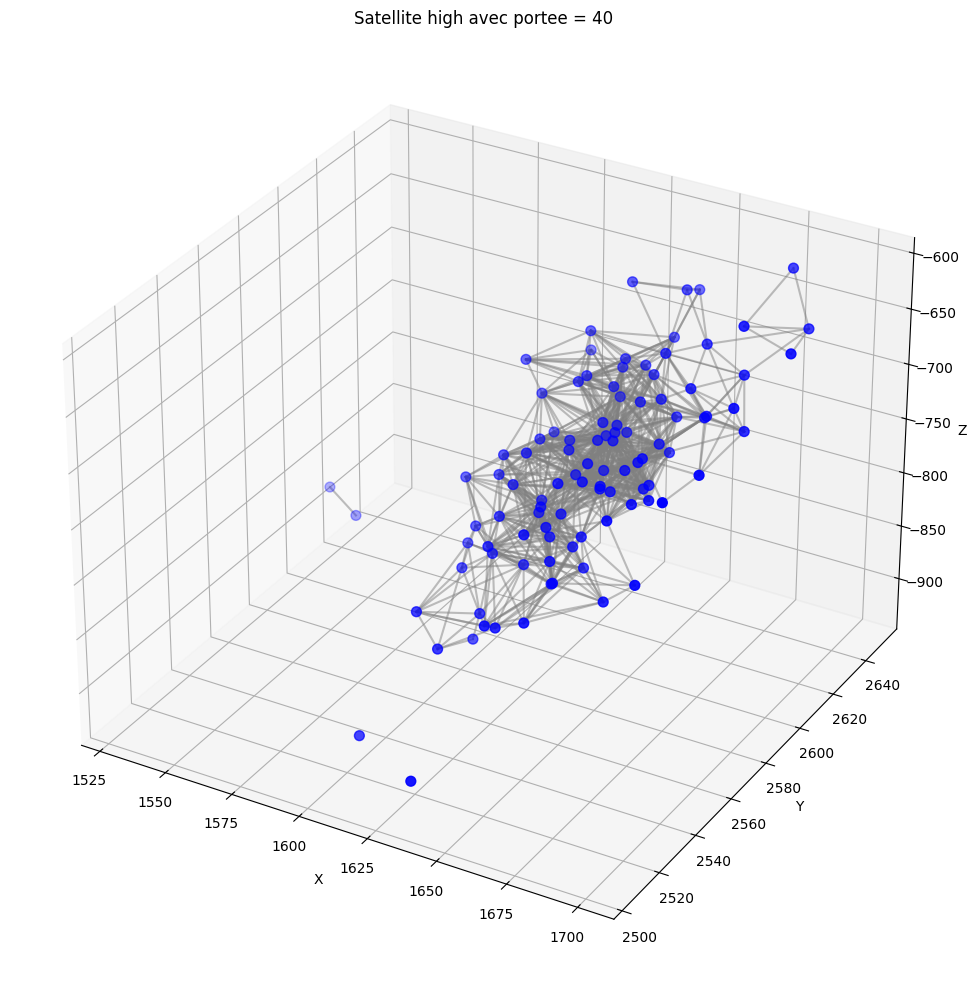

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 934
Degrée moyen du graph: 18.68
Coefficient de clustering moyen: 0.6650585170179752
Nombre de composantes connexes: 4
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4561
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 301224

Matrice des longueurs des chemins les plus courts:
 
      0    1    2    3    4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  2.0  4.0  5.0  4.0  2.0  2.0  1.0  3.0  2.0  ...  2.0  2.0  1.0  5.0   
7   1.0  1.0  4.0  4.0  3.0  2.0  2.0  0.0  2.0  2.0  ...  1.0  3.0  1.0  4.0   
17  1.0  2.0  4.0  5.0  4.0  1.0  2.0  1.0  3.0  2.0  ...  1.0  2.0  1.0  5.0   
21  1.0  2.0  4.0  5.0  4.0  2.0  2.0  1.0  3.0  2.0  ...  2.0  3.0  1.0  5.0   
27  1.0  2.0  4.0  5.0  4.0  1.0  2.0  1.0  3.0  2.0  ...  1.0  2.0  1.0  5.0

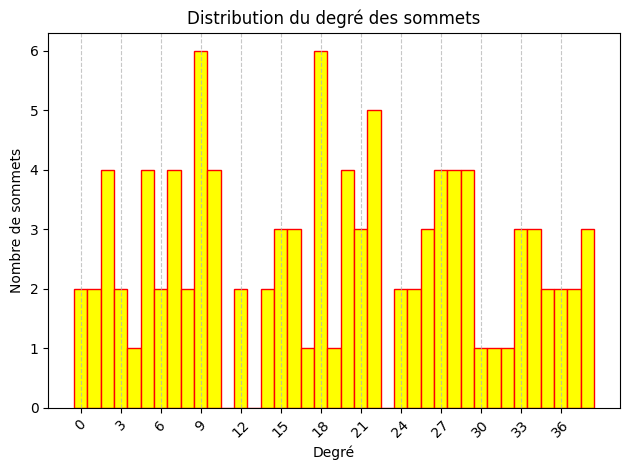

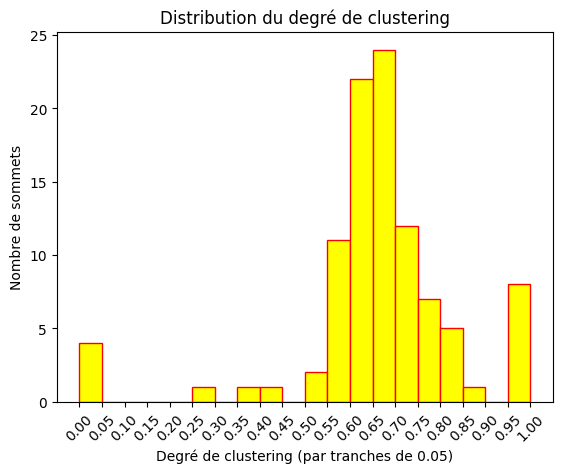

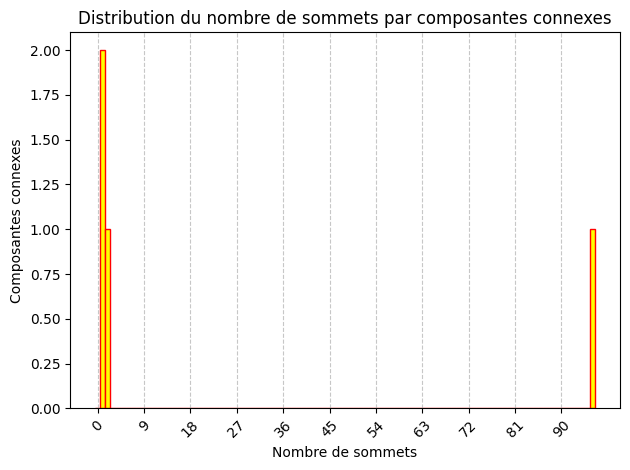

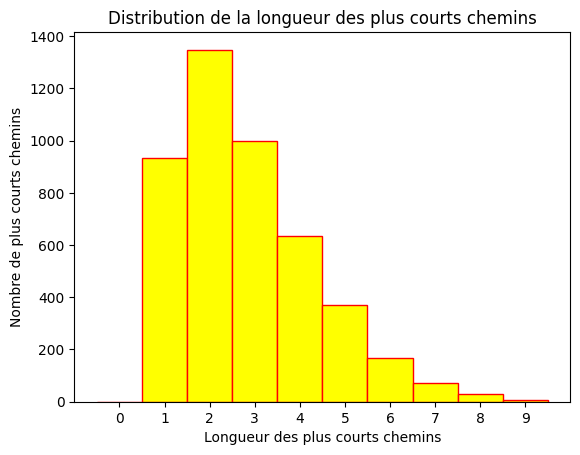

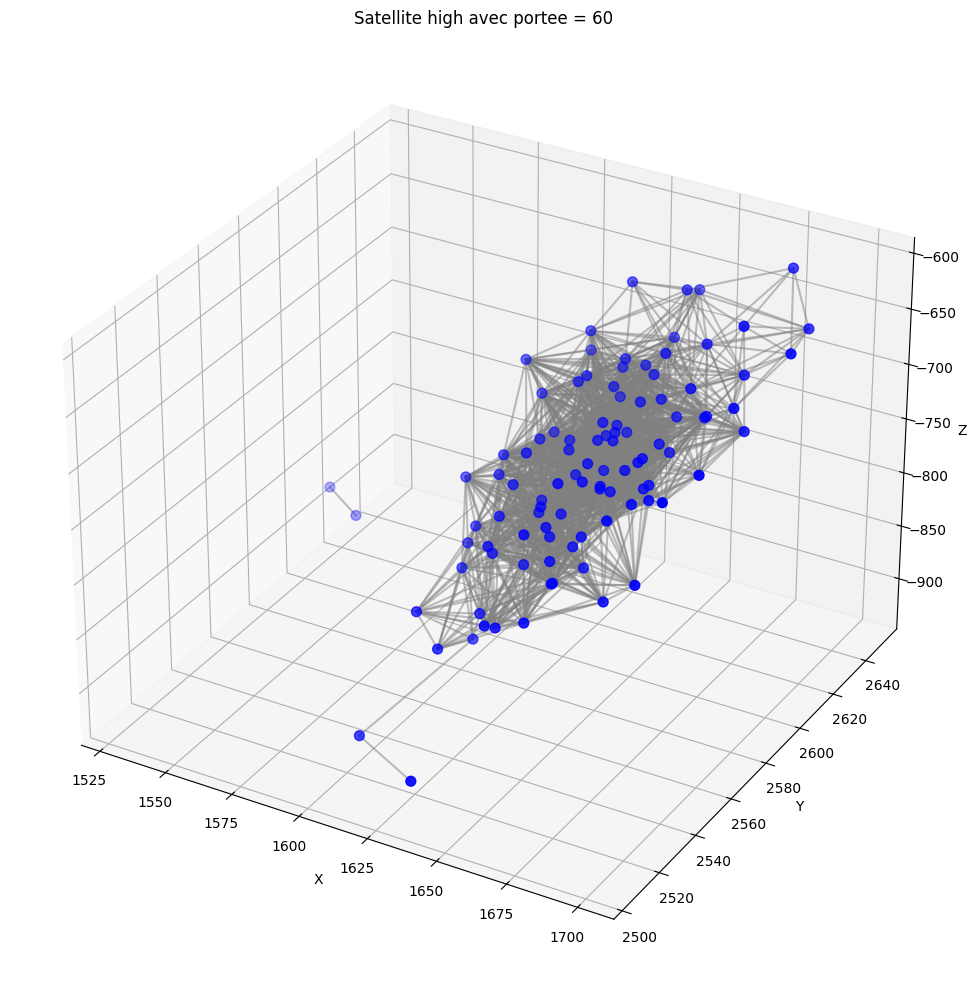

-----------------------------------------Information sur le graphe-----------------------------------------
Nombre de noeud: 100
Nombre d'arêtes: 1870
Degrée moyen du graph: 37.4
Coefficient de clustering moyen: 0.7280564598604691
Nombre de composantes connexes: 2
Nombre de plus courts chemins en considérant un seul chemin court entre 02 sommets: 4754
Nombre total de plus courts chemins en considérant tous les chemins courts possibles entre 02 sommets: 355757

Matrice des longueurs des chemins les plus courts:
 
      0    1    2    3    4    5    6    7    8    9  ...   90   91   92   93  \
0   0.0  1.0  2.0  3.0  3.0  1.0  2.0  1.0  2.0  2.0  ...  1.0  2.0  1.0  3.0   
1   1.0  0.0  3.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  2.0  1.0  2.0   
5   1.0  2.0  2.0  4.0  3.0  0.0  2.0  1.0  3.0  2.0  ...  1.0  1.0  1.0  3.0   
7   1.0  1.0  3.0  3.0  2.0  1.0  1.0  0.0  2.0  1.0  ...  1.0  2.0  1.0  2.0   
12  1.0  1.0  3.0  3.0  2.0  2.0  1.0  1.0  1.0  1.0  ...  1.0  2.0  1.0  2.0

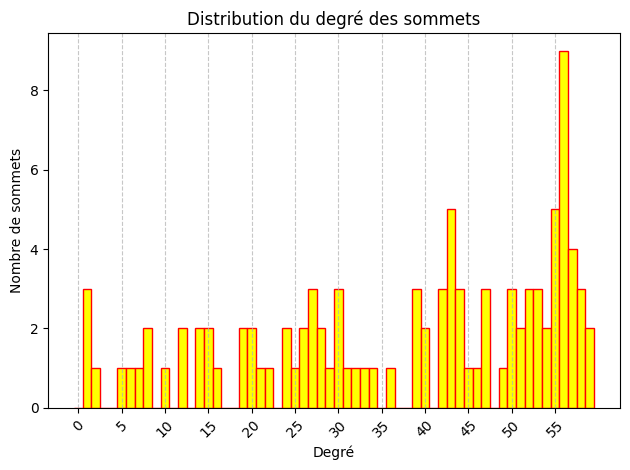

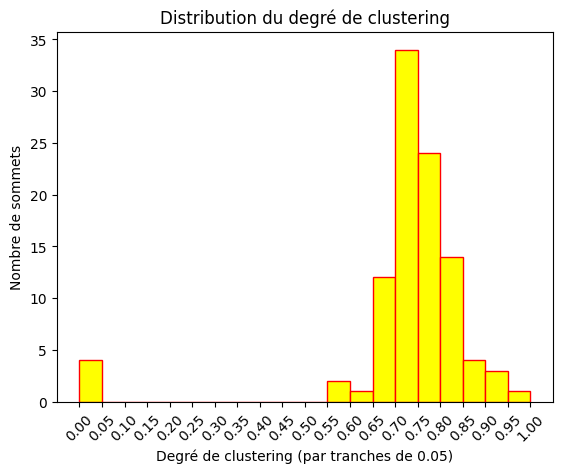

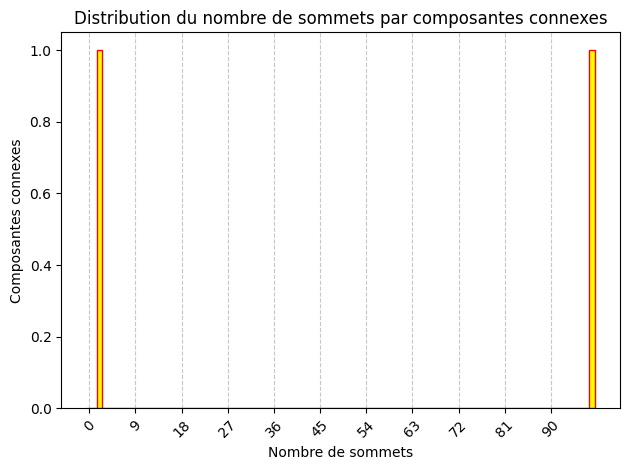

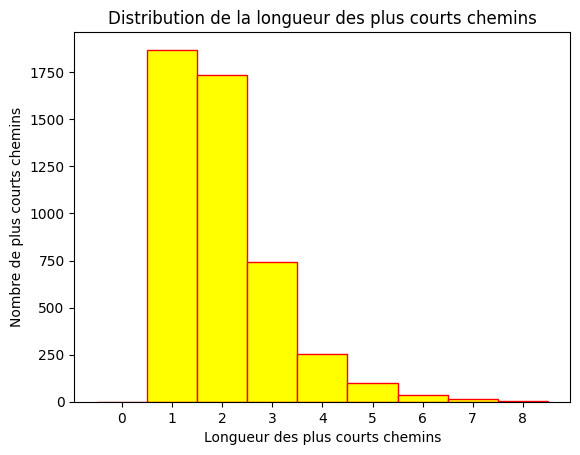

In [12]:
#Pour afficher uniquement pour un seul fichier et par portée, decommentez les lignes appropriées
#cela affichera toutes les informations d'un graphe en particulier.Ne pas alors oublier de commenter analyze_all
#Pour afficher toutes les informations de tous les graphes , decommentez juste analyze_all(False)
#Par défaut, les histogrammes ne seront pas affichés. 
#Pour les afficher, il suffit de remplacer le paramètre booleen à True, si contraitre, mettre à False
#le nombre de cliques et leur ordre n'est pas traité ici , car déjà traité plus haut

analyze_all(True)

topology_low_csv_path='Configuration/topology_low.csv'
topology_avg_csv_path='Configuration/topology_avg.csv'
topology_high_csv_path='Configuration/topology_high.csv'

#plot_satellite(topology_low_csv_path,20, 'Satellite low', False)
#plot_satellite(topology_low_csv_path,40, 'Satellite low', False)
#plot_satellite(topology_low_csv_path,60, 'Satellite low', False)


#plot_satellite(topology_avg_csv_path,20, 'Satellite average', False)
#plot_satellite(topology_avg_csv_path,40, 'Satellite average', False)
#plot_satellite(topology_avg_csv_path,60, 'Satellite average', False)


#plot_satellite(topology_high_csv_path,20, 'Satellite High', False)
#plot_satellite(topology_high_csv_path,40, 'Satellite High', False)
#plot_satellite(topology_high_csv_path,60, 'Satellite High', False)